In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from joblib import Parallel, delayed
from multiprocessing import  Pool
from astropy.io import ascii
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# Import
from pandarallel import pandarallel
from scipy.interpolate import interp1d
# Initialization
pandarallel.initialize(nb_workers=22)

INFO: Pandarallel will run on 22 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
plt.style.use('/home/luuk/Documents/MNRAS_stylesheet')

Duplicate key in file '/home/luuk/Documents/MNRAS_stylesheet' line #41.
Duplicate key in file '/home/luuk/Documents/MNRAS_stylesheet' line #50.


<h3>Fucntions</h3>

In [35]:
def interp_func(x, bins, delta, running_median):
    f = interpolate.interp1d(x=bins-delta/2,y=running_median, fill_value='extrapolate')
    return f(x)

<h3>Identify PMS Stars</h3>

In [36]:
wfc3_catalogue = Table.read('../ResearchProject2/HST_Guido/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
wfc3_catalogue.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
wfc3_catalogue = wfc3_catalogue.set_index('ID')

In [37]:
ACS_catalogue = pd.read_pickle('../ResearchProject2/LargeField/FullCatalogue.updatedWCS.pickle')

In [38]:
def get_pms_IDs(df, type='wfc3'):
    if type=='wfc3':
        vmag, evmag   = 'v_1',  'ev_2'
        hamag, ehamag = 'ha_1', 'eha_2'
        imag, eimag   = 'i_1' , 'ei_2'
    elif type=='ACS':
        vmag, evmag   = 'm555',  'e555'
        hamag, ehamag = 'm658', 'e658'
        imag, eimag   = 'e658' , 'e75'
        df['m75'] = df[['m75a','m75u']].min(axis=1)
        df['e75'] = df[['e75a','e75u']].min(axis=1)
        df['q75'] = df[['q75a','q75u']].max(axis=1)
        df = df[(df.q658>0.75)&(df.q555>0.75)&(df.q75>0.75)]
    df = df[(df[evmag]<0.07)&(df[eimag]<0.07)&(df[ehamag]<0.07)]
    df = df[(df[vmag]>0)&(df[hamag]>0)&(df[imag]>0)&(df[vmag]<90)&(df[hamag]<90)&(df[imag]<90)]
    VI_color  = df[vmag] - df[imag]
    VHa_color = df[vmag] - df[hamag]
    
    total_bins = 30
    bins = np.linspace(0.1,0.98*VI_color.max(), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(VI_color,bins)
    running_median = np.array([np.median(VHa_color[idx==k]) for k in range(total_bins)])
    
    VHa_interp = interp_func(VI_color, bins, delta, running_median)
    df['HaExcess'] = VHa_color - VHa_interp
    df['HaExcessSigma'] = df['HaExcess'] / df[ehamag]
    print((df['HaExcessSigma']>5).sum())
    plt.scatter(VI_color[df['HaExcessSigma']>3], VHa_color[df['HaExcessSigma']>3],s=1, color='red')
    plt.scatter(VI_color, VHa_color,s=0.1)
    plt.plot(bins-delta/2, running_median, ls='--', c='black')
    plt.xlim(-0.5,3)
    plt.ylim(-0.5,5)
    #return df
#get_pms_IDs(wfc3_catalogue, type='wfc3')

In [39]:
all_stars_read = Table.read('../ResearchProject2/HST_Guido/30dor_all_newerr.UBVIHa.rot', format='ascii').to_pandas()
all_stars_read.columns = 'ID;x;y;RA;Dec;u_1;eu_2;b_1;eb_2;v_1;ev_2;i_1;ei_2;ha_1;eha_2'.split(';')
all_stars_read = all_stars_read.set_index('ID')

pms = ascii.read('../ResearchProject2/HST_Guido/30dorallpmsstars.txt').to_pandas()
distances = np.sqrt((pms.X.values - all_stars_read.x.values[:,np.newaxis])**2+(pms.Y.values - all_stars_read.y.values[:,np.newaxis])**2).T
argmins  = np.argmin(distances, axis=1)
mindists = np.min(distances, axis=1)
argmins = argmins[mindists<0.5]
pms_stars = all_stars_read.iloc[argmins]
pms_ids=pms_stars.index
pms_ids


Int64Index([   39,   151,   181,   202,   325,   404,   422,   424,   444,
              610,
            ...
             4806,  7434,  8632,  5324,  6260,  5922, 12335,  6536,  5507,
            12885],
           dtype='int64', name='ID', length=1396)

In [40]:
def get_PMS_info_df():
    distances = np.sqrt((pms.set_index('NR')['X'].values - pms_stars['x'].values[:,np.newaxis])**2 + (pms.set_index('NR')['Y'].values - pms_stars['y'].values[:,np.newaxis])**2)
    argmins  = np.argmin(distances, axis=0)
    mindists = np.min(distances, axis=0)
    pms2 = pms.copy()
    pms2['WFC3_ID'] = pms_stars.iloc[argmins].index
    pms2 = pms2[mindists<0.5]
    pms2 = pms2.set_index('WFC3_ID').drop('NR', axis=1)
    return pms2
pms_df = get_PMS_info_df()

<h3>Identify mergers</h3>

In [41]:
deltaX  = all_stars_read.x.values - all_stars_read.x.values[:,np.newaxis]
deltaY  = all_stars_read.y.values - all_stars_read.y.values[:,np.newaxis]
deltaPix = np.array(np.sqrt(deltaX**2+deltaY**2), dtype=np.float32)

deltaPix = pd.DataFrame(deltaPix, index=np.arange(1,len(deltaPix)+1,1), columns = np.arange(1,len(deltaPix)+1,1))
deltaPix[deltaPix==0] = 999
mindists = deltaPix.min(axis=1)
notmerged = mindists.index[mindists>=6]

In [42]:
ACS_pms_df = ascii.read('../ResearchProject2/LargeField/pmscatalogueluuk160320.txt').to_pandas()

<h3>Ha plot </h3

In [43]:
mha, eha = all_stars_read['ha_1'],all_stars_read['eha_2']
mask = (mha<80)*(mha>0)*(eha>0)*(eha<2)
mha = mha[mask]
eha = eha[mask]

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


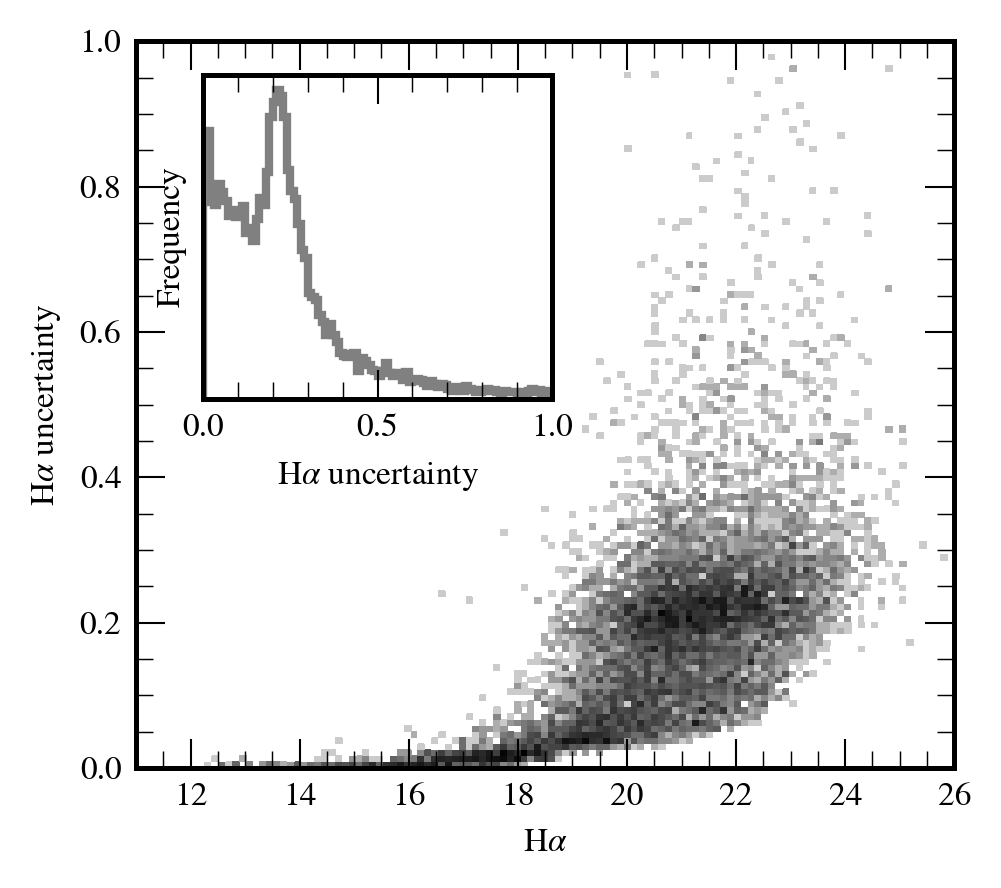

In [44]:
fig, ax1 = plt.subplots()#figsize=(8,5))
left, bottom, width, height = [0.21, 0.55, 0.35, 0.36]
ax2 = fig.add_axes([left, bottom, width, height])
#ax2.set_xticks([])
ax2.set_yticks([])
ax2.hist(eha, bins=np.arange(0,1.5,0.01), histtype='step', color='grey', label='Mag uncertainties', lw=2)
ax2.set_xlabel(r'H$\alpha$ uncertainty')#, size=14)
ax2.set_ylabel('Frequency')
ax2.set_xlim(0,1)
#ax3 = ax2.twiny()
#ax3.hist(mha, bins=np.arange(14,30,0.18), histtype='step', color='grey', linestyle='dashed', label='Magnitudes',lw=2)
#ax3.set_xlabel(r'H$\alpha$ magnitude', size=14)

ax1.hist2d(mha, eha,bins=(np.linspace(11,26,120),np.linspace(0,1,120)),cmap='gray_r', norm=LogNorm())#, s=0.02, edgecolor='grey', facecolor='grey')
#ax1.scatter(mha.loc[pms_ids], eha.loc[pms_ids], s=0.3, color='red')

ax1.set_xlabel(r'H$\alpha$')#, size=15)
ax1.set_ylabel(r'H$\alpha$ uncertainty')#, size=15)
ax1.set_xlim(11,26)
ax1.set_ylim(0,1)



h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
#h3, l3 = ax3.get_legend_handles_labels()
h = np.hstack((h1,h2))
l = np.hstack((l1,l2))

plt.tight_layout()
#ax1.legend(h,l,loc='upper right', fontsize=15)
plt.savefig('Giacomo_Ha_err.pdf', dpi=500)
plt.show()

<h3> WFC3 Broadband </h3>

In [45]:
wfc3_broadband_df = pd.read_pickle('./WFC3_Broadband/WFC3_broadband_photometry.pickle')
nmeas = wfc3_broadband_df.groupby(['ID','Filter'])['mag'].nunique()>=5
nmeas = nmeas.index[nmeas]
three_con = wfc3_broadband_df[(wfc3_broadband_df.index.get_level_values(2)>55129.3) * (wfc3_broadband_df.index.get_level_values(2)<55130)]
wfc3_broadband_df = wfc3_broadband_df.reset_index().set_index(['ID','Filter']).loc[nmeas]
three_con = pd.DataFrame({'STDerror':three_con.groupby(['ID','Filter'])['mag'].std().dropna()})
wfc3_broadband_df = pd.merge(wfc3_broadband_df,three_con, left_index=True,right_index=True, how='left')
wfc3_broadband_df.loc[wfc3_broadband_df.STDerror.isna(),'STDerror'] = wfc3_broadband_df.loc[wfc3_broadband_df.STDerror.isna()]['emag']
wfc3_broadband_df = wfc3_broadband_df.reset_index().set_index(['ID','Filter','obsdate'])

In [46]:
a = (wfc3_broadband_df['STDerror'])
b = wfc3_broadband_df['emag']
mask = a!=b
a=a[mask]
b=b[mask]

In [47]:
(a/b).median()

1.1874999999999531

In [48]:
wfc3_broadband_df['emag'] = wfc3_broadband_df[['emag','STDerror']].max(axis=1)
wfc3_broadband_df = wfc3_broadband_df[wfc3_broadband_df.emag<0.07]

In [49]:
#(wfc3_broadband_df['emag'] == wfc3_broadband_df['STDerror']).sum() / (wfc3_broadband_df['emag'] == wfc3_broadband_df['STDerror']).count()

In [50]:
def GetMad():
    MAD = (wfc3_broadband_df.groupby(['ID','Filter', 'obsdate'])['mag'].median() - wfc3_broadband_df.groupby(['ID','Filter'])['mag'].median()).abs().groupby(['ID','Filter']).median()
    MAG = wfc3_broadband_df.groupby(['ID','Filter'])['mag'].median()
    idxmax = (wfc3_broadband_df.groupby(['ID','Filter'])['mag'].idxmax())
    idxmin = (wfc3_broadband_df.groupby(['ID','Filter'])['mag'].idxmin())
    eMAD = np.sqrt(wfc3_broadband_df.loc[idxmax]['emag'].droplevel(2)**2 + wfc3_broadband_df.loc[idxmin]['emag'].droplevel(2)**2)
    return pd.DataFrame({'MAG':MAG, 'MAD':MAD, 'eMAD':eMAD})
MagMadeMAD = GetMad()

In [51]:
wfc3_broadband_df.reset_index().groupby('Filter')['ID'].nunique()

Filter
F336W     3607
F438W     3502
F555W     7924
F814W    12303
Name: ID, dtype: int64

In [52]:
x=wfc3_catalogue.loc[wfc3_broadband_df.index.get_level_values(0).unique()].x.values
y=wfc3_catalogue.loc[wfc3_broadband_df.index.get_level_values(0).unique()].y.values
dist=(x - x[:,np.newaxis])**2 + (y - y[:,np.newaxis])**2

In [53]:
dist[dist==0]=9999
(np.sum((np.min(dist,axis=0))<8) / len(((np.min(dist,axis=0))<6)))*100

0.9713158294126575

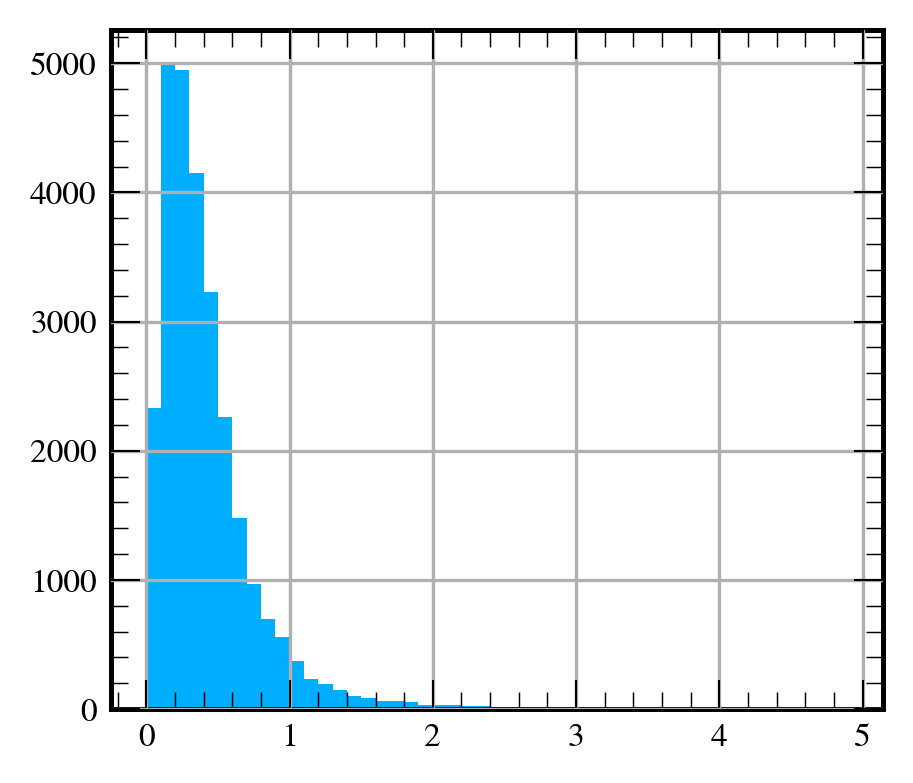

In [54]:
def madbins(df):
    df['MAGbin'] = pd.cut(df.MAG, bins=np.arange(14,26,0.25)).apply(lambda x: x.mid)
    medmad = pd.DataFrame({'MedianMAD':df.groupby('MAGbin')['MAD'].median()})
    df = pd.merge(df, medmad, left_on='MAGbin', right_index=True)
    df['MAD_sigma_medmad'] = df.MAD / df.MedianMAD
    df['MAD_sigma_emag'] = df.MAD / df.eMAD
    df['MAD_sigma'] = df[['MAD_sigma_emag','MAD_sigma_medmad']].min(axis=1)
    return df
MagMadeMAD = madbins(MagMadeMAD)
MagMadeMAD.MAD_sigma.hist(bins=np.arange(0,5,0.1))

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


F336W 3016
52
1.7241379310344827
F438W 3028
60
1.9815059445178336
F555W 6877
139
2.0212301875817946
F814W 10644
298
2.799699361142428


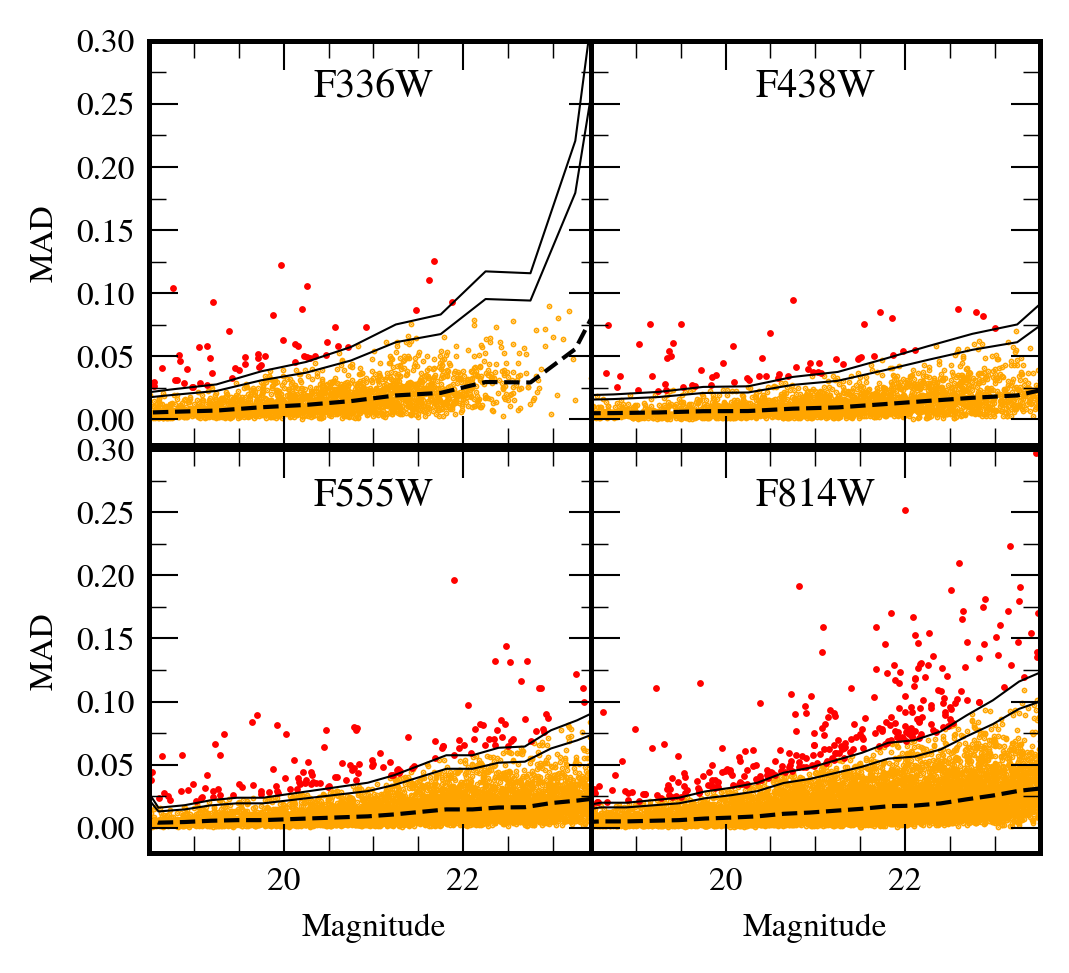

In [55]:
def continuum_variation_plot():
    #plt.figure(figsize=(8,5))
    plt.figure()#figsize=(8,9))
    i=1
    variable = []
    for filter_ in ['F336W','F438W','F555W','F814W']:
        
        ax  =plt.subplot('22'+str(i))
        if filter_ in ['F555W', 'F814W']:
            plt.xlabel('Magnitude')
            plt.xticks(np.arange(18,23.5,2))
        else:
            plt.xticks(ticks=np.arange(18,23.5,2), labels=len(np.arange(18,23.5,2))*[''])
            
        if filter_ in ['F438W', 'F814W']:
            plt.yticks(ticks=np.arange(0,0.31,0.05),labels=7*[''])
        else:
            plt.ylabel('MAD')
            plt.yticks(np.arange(0,0.31,0.05))
        #else:
            
        i+=1
        plt.title(filter_, y=0.8)#,x=0.3)
        plt.ylim(-0.02,0.3)
        df = MagMadeMAD[MagMadeMAD.index.get_level_values(1)==filter_].loc[notmerged].dropna()
        
        total_bins = (15 if filter_ in ['F336W','F438W'] else 25)
        bins = np.linspace(17,24, total_bins)
        delta = bins[1]-bins[0]
        idx  = np.digitize(df.MAG,bins)
        running_median = np.array([np.median(df.MAD[idx==k]) for k in range(total_bins)])
        running_median_eMAD = np.array([np.nanstd(df.MAD[idx==k]) for k in range(total_bins)])
        all_y_interp = interp_func(df.MAG,bins, delta, running_median)
        two_sigma_above = all_y_interp +2*1.48*all_y_interp#+ 1.5*1.48*all_y_interp
        
        x = (df.MAD>two_sigma_above)*(df.MAG>18.5)
        x = x[x].index
        print(filter_,len(df.MAG))
        print(len(x))
        print(len(x)/len(df.MAG)*100)
        plt.scatter(df.MAG, df.MAD, edgecolor='orange',s=0.15,marker='o',facecolor='orange')
        plt.scatter(df.MAG.loc[x], df.MAD.loc[x], edgecolor='red',s=0.4,marker='o',facecolor='red')
        #plt.scatter(df.MAG.loc[wfc3_ha_x], df.MAD.loc[wfc3_ha_x], edgecolor='purple',s=2,marker='o',facecolor='purple')
        
        plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
        plt.plot(bins-delta/2, running_median*(1+1.5*1.48), color='black', lw=0.5)
        plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=0.5)
        plt.xlim(18.5,23.5)
        
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        #plt.axvline(18.5, linestyle='dotted', color='black',linewidth=1)
        #plt.xlabel('Magnitude', size=15)
        #plt.ylabel(r'Median Absolute Deviation', size=15)
        for star in x:
            variable.append((star[0], star[1]))
    plt.tight_layout(pad=-0.2)
    plt.savefig('MAG_MAD_broadbands.pdf',dpi=500,bbox_inches='tight')
    plt.show()
    return(variable)
continuum_variables = continuum_variation_plot()

In [56]:
wfc3_catalogue.loc[[w[0] for w in continuum_variables if w[1]=='F555W']][['x','y']].to_csv('2sigmaMAD_F555W.coords',index=None,header=None,sep='\t')

In [59]:
a=pd.DataFrame(continuum_variables)
a.columns=['Star','Filter']
a.groupby('Star')['Filter'].nunique().value_counts()

1    797
2     61
3     15
4      3
Name: Filter, dtype: int64

In [28]:
pms_stars.loc[[w[0] for w in continuum_variables]].dropna()

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,x,y,RA,Dec,u_1,eu_2,b_1,eb_2,v_1,ev_2,i_1,ei_2,ha_1,eha_2
ID,,,,,,,,,,,,,,
2827,3922.249,2825.510,84.649883,-69.074930,19.505,0.0280,20.322,0.0170,20.061,0.0150,19.449,0.0140,20.368,0.159
1960,3552.263,3737.244,84.661119,-69.065054,18.879,0.0200,19.417,0.0190,19.255,0.0180,18.949,0.0180,18.590,0.139
2475,3708.061,2700.634,84.656378,-69.076284,19.373,0.0990,20.118,0.0700,19.779,0.0570,18.903,0.0710,17.575,0.070
5623,3571.263,3272.838,84.660536,-69.070086,21.952,0.0340,21.892,0.0250,21.597,0.0270,21.108,0.0240,20.097,0.198
3579,4421.679,3867.742,84.634762,-69.063634,20.247,0.0740,20.756,0.0180,20.561,0.0180,20.173,0.0180,19.633,0.170
4066,4225.321,3573.308,84.640708,-69.066826,21.007,0.1390,20.975,0.0420,20.823,0.0620,20.432,0.0370,18.841,0.194
6565,3928.593,2719.779,84.649688,-69.076075,21.946,0.1800,22.782,0.0630,22.040,0.0300,20.705,0.0290,19.526,0.164
5461,4141.617,2169.805,84.643213,-69.082032,21.737,0.0560,21.828,0.0310,21.518,0.0240,20.861,0.0290,21.411,0.190
2475,3708.061,2700.634,84.656378,-69.076284,19.373,0.0990,20.118,0.0700,19.779,0.0570,18.903,0.0710,17.575,0.070


(-2, 5)

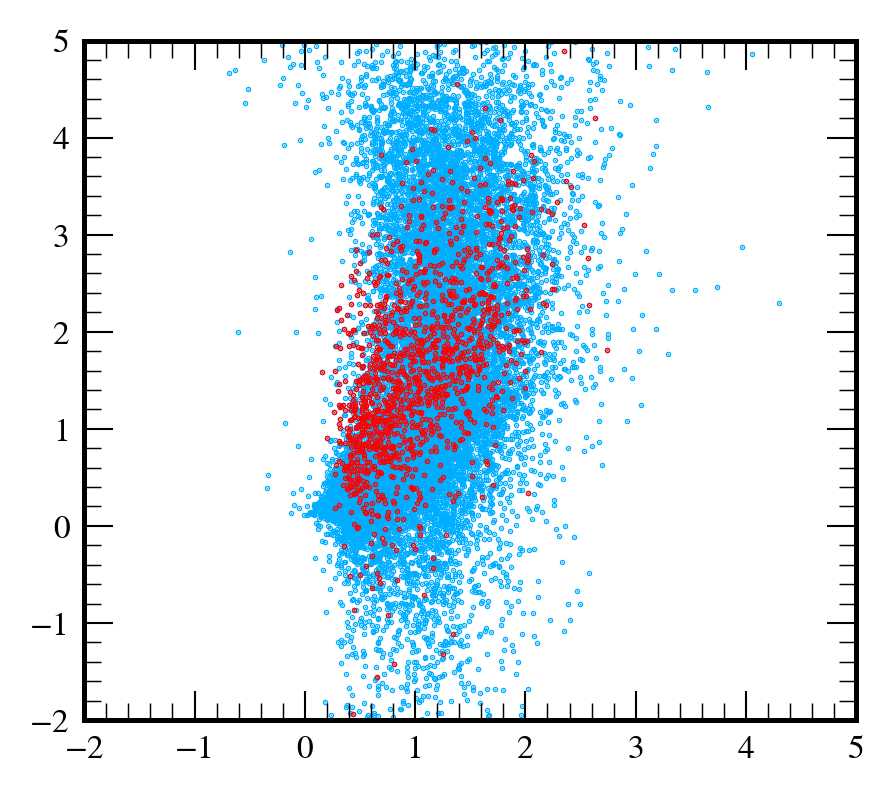

In [29]:
plt.scatter(wfc3_catalogue.v_1-wfc3_catalogue.i_1,wfc3_catalogue.v_1-wfc3_catalogue.ha_1,s=0.1)
plt.scatter(pms_stars.v_1-pms_stars.i_1,pms_stars.v_1-pms_stars.ha_1,s=0.1,color='red')
plt.xlim(-2,5)
plt.ylim(-2,5)

In [30]:
wfc3_catalogue.loc[[w[0] for w in continuum_variables]]

,x,y,RA,Dec,u_1,eu_2,b_1,eb_2,v_1,ev_2,i_1,ei_2,ha_1,eha_2
ID,,,,,,,,,,,,,,
2955,3471.900,2510.116,84.663540,-69.078349,20.001,0.065,20.518,0.062,20.158,0.062,19.411,0.069,19.732,0.800
3051,3668.126,3144.391,84.657597,-69.071477,19.627,0.023,20.398,0.019,20.232,0.017,19.824,0.018,19.958,0.113
3088,3699.382,3716.399,84.656658,-69.065279,20.193,0.078,20.477,0.036,20.255,0.037,19.930,0.037,19.933,0.101
4281,3439.629,2520.345,84.664519,-69.078239,20.563,0.188,21.298,0.069,20.933,0.086,20.455,0.180,20.868,-99.000
5656,3582.441,2278.808,84.660183,-69.080855,21.622,0.152,22.410,0.035,21.617,0.076,20.348,0.026,21.060,0.165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18858,1554.578,1626.771,84.721723,-69.087919,27.750,0.210,26.099,0.062,25.275,0.078,23.976,0.043,-99.000,-99.000
20451,834.421,2468.730,84.743560,-69.078791,27.326,0.323,26.641,0.071,25.644,0.075,23.938,0.029,-99.000,-99.000
22029,2994.518,1265.670,84.678016,-69.091833,30.104,0.658,28.663,0.402,26.523,0.119,23.916,0.036,-99.000,0.386


Length our data 7244
Length marchi 2011 data 12683
123


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/s

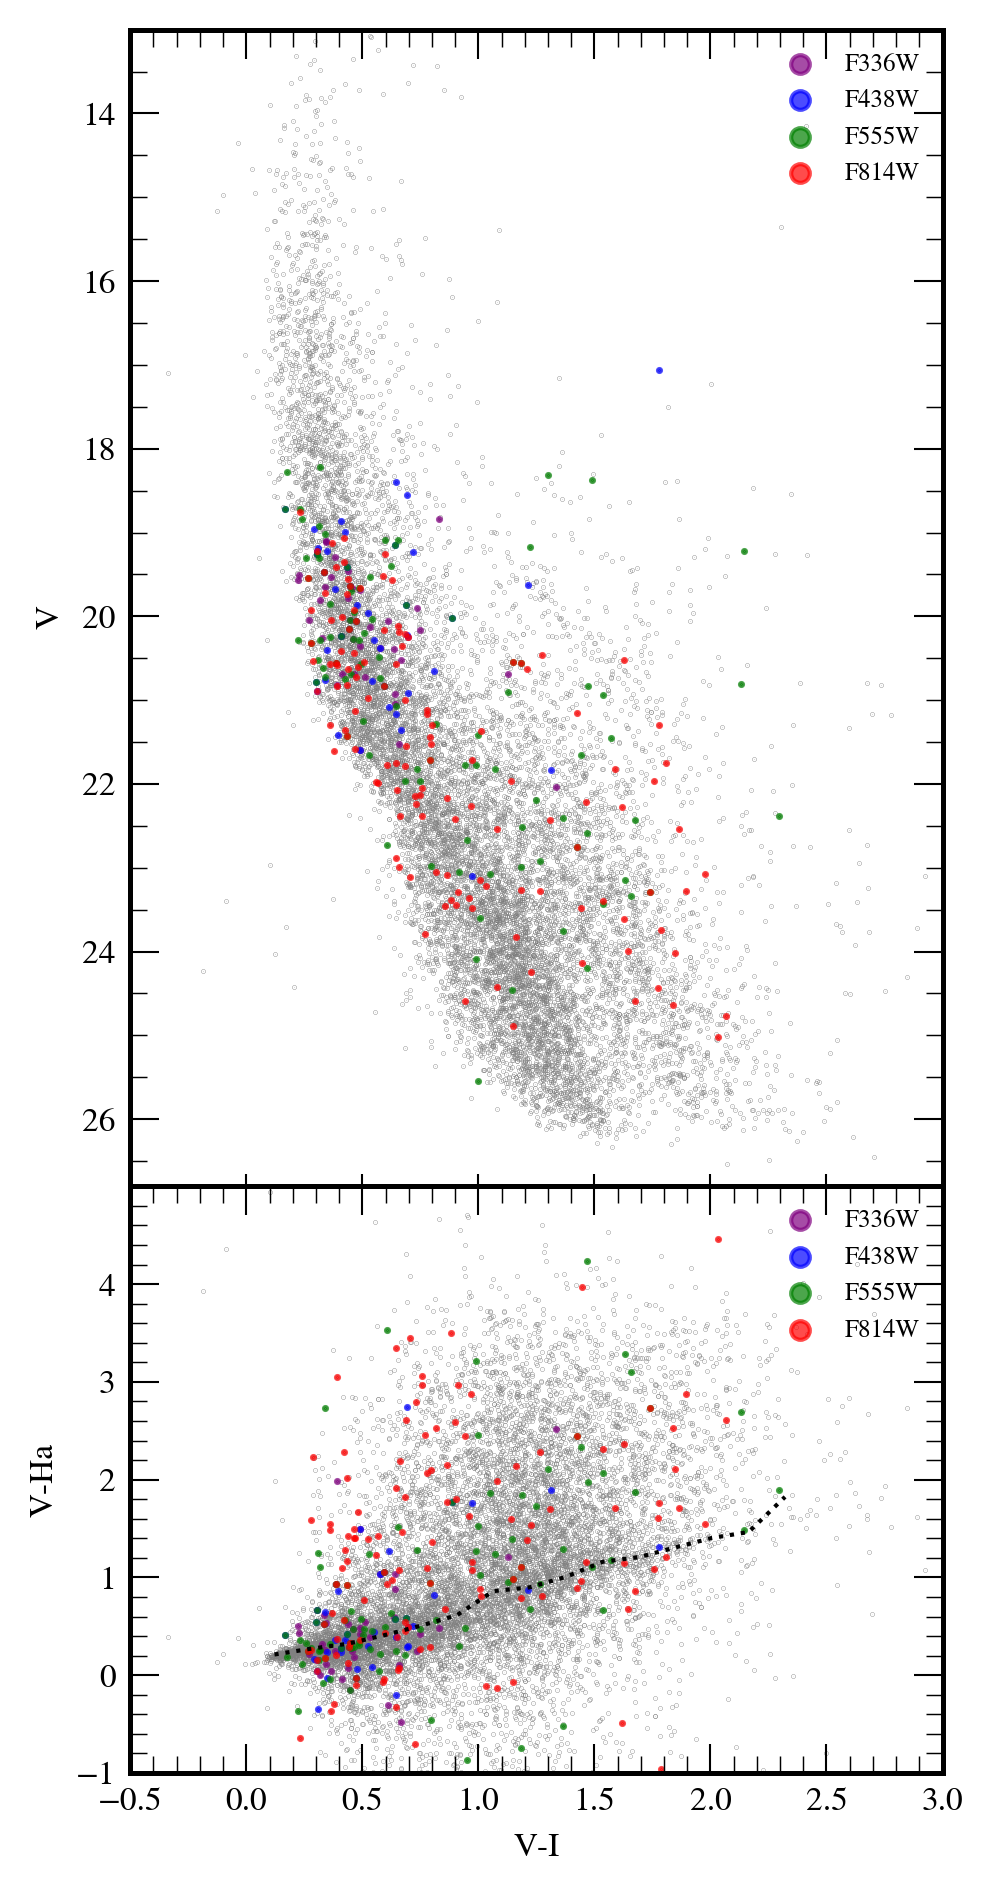

In [31]:
def plot_HR_with_vars():
    from matplotlib import gridspec
    fig = plt.figure(figsize=(3, 6)) 
    gs = gridspec.GridSpec(2,1, height_ratios=[2, 1]) 
    plt.subplot(gs[0])
    
    
    df = pd.DataFrame({'MAG':wfc3_broadband_df.groupby(['ID','Filter'])['mag'].median(),
                       'eMAG':wfc3_broadband_df.groupby(['ID','Filter'])['emag'].mean()})
    
    df = df[df.eMAG<0.07]
    df = df[(df.index.get_level_values(1)=='F555W')+(df.index.get_level_values(1)=='F814W')]
    df = df.unstack().dropna()
    print("Length our data",len(df))
    all_stars_lowerr = all_stars_read[(all_stars_read.ei_2<0.07)&(all_stars_read.ev_2<0.07)]
    all_stars_lowerr = all_stars_lowerr[(all_stars_lowerr.v_1<80)&(all_stars_lowerr.v_1>-80)&(all_stars_lowerr.i_1<80)&(all_stars_lowerr.i_1>-80)&(all_stars_lowerr.ha_1<80)&(all_stars_lowerr.ha_1>-80)]
    
    all_stars_lowerr_ha = all_stars_lowerr[all_stars_lowerr.eha_2<0.07]
    
    print("Length marchi 2011 data",len(all_stars_lowerr))

    
    
    this_work = df.index
    VI = all_stars_lowerr.v_1 - all_stars_lowerr.i_1
    V  = all_stars_lowerr.v_1
    
    VI_ref = all_stars_lowerr_ha.v_1 - all_stars_lowerr_ha.i_1
    VHa_ref = all_stars_lowerr_ha.v_1 - all_stars_lowerr_ha.ha_1
    
    
    plt.scatter(VI, V,edgecolor='grey', facecolor='black', s=0.01,marker='o',alpha=1)
    
    U_var = [w[0] for w in continuum_variables if w[1]=='F336W']
    B_var = [w[0] for w in continuum_variables if w[1]=='F438W']
    V_var = [w[0] for w in continuum_variables if w[1]=='F555W']
    I_var = [w[0] for w in continuum_variables if w[1]=='F814W']
    
    
    
    plt.scatter(VI.loc[U_var], V.loc[U_var], edgecolor='purple', facecolor='purple', marker='o', s=0.5,label='F336W',alpha=0.7)
    plt.scatter(VI.loc[B_var], V.loc[B_var], edgecolor='blue', facecolor='blue', marker='o', s=0.5,label='F438W',alpha=0.7)
    plt.scatter(VI.loc[V_var], V.loc[V_var], edgecolor='green', facecolor='green', marker='o', s=0.5,label='F555W',alpha=0.7)
    plt.scatter(VI.loc[I_var], V.loc[I_var], edgecolor='red', facecolor='red', marker='o', s=0.5,label='F814W',alpha=0.7)
    
    plt.ylabel(r'V')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(27,13)
    plt.xticks(ticks=np.arange(-0.5,3.01,0.5),labels=7*[''])
    lgnd = plt.legend(numpoints=1,fontsize=6, loc='upper right')
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    lgnd.legendHandles[3]._sizes = [20]
    
    #lgnd.legendHandles[1]._colors = ['black']
    #lgnd.legendHandles[1]._alphas = [1]
    #lgnd.legendHandles[2]._sizes = [10]
    plt.subplot(gs[1])
    VHa  = all_stars_lowerr.v_1 - all_stars_lowerr.ha_1
    
    
    plt.scatter(VI, VHa,color='grey', s=0.01,marker='o',alpha=1)
    
    U_var = [w[0] for w in continuum_variables if w[1]=='F336W']
    B_var = [w[0] for w in continuum_variables if w[1]=='F438W']
    V_var = [w[0] for w in continuum_variables if w[1]=='F555W']
    I_var = [w[0] for w in continuum_variables if w[1]=='F814W']
    all_var = np.unique([w[0] for w in continuum_variables])

    
    plt.scatter(VI.loc[U_var], VHa.loc[U_var], edgecolor='purple', facecolor='purple', marker='o', s=0.5,label='F336W',alpha=0.7)
    plt.scatter(VI.loc[B_var], VHa.loc[B_var], edgecolor='blue', facecolor='blue', marker='o', s=0.5,label='F438W',alpha=0.7)
    plt.scatter(VI.loc[V_var], VHa.loc[V_var], edgecolor='green', facecolor='green', marker='o', s=0.5,label='F555W',alpha=0.7)
    plt.scatter(VI.loc[I_var], VHa.loc[I_var], edgecolor='red', facecolor='red', marker='o', s=0.5,label='F814W',alpha=0.7)
    
    total_bins = 15
    bins = np.linspace(0.2,2.4, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(VI_ref,bins)
    running_median = np.array([np.median(VHa_ref[idx==k]) for k in range(total_bins)])
    
    
    VI_var = VI.loc[all_var].dropna()
    VHa_var = VHa.loc[all_var].dropna()

    
    
    var_y_interp = interp_func(VI_var, bins, delta, running_median)
    
    sigma = np.sqrt(all_stars_lowerr.ev_2.loc[VHa_var.index]**2+all_stars_lowerr.eha_2.loc[VHa_var.index]**2)
    print(np.sum((VHa_var - (var_y_interp))>0.25))
    
    
    
    plt.plot(bins-delta/2,running_median, lw=1,ls='dotted',color='black')   
    
    plt.xlabel('V-I')
    plt.ylabel(r'V-Ha')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(-1,5)
    plt.yticks(np.arange(-1,5))
    lgnd = plt.legend(numpoints=1,fontsize=6, loc='upper right')
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    lgnd.legendHandles[3]._sizes = [20]
    
    plt.tight_layout(pad=-0.5)
    plt.savefig('Variables_continuum_CMD.pdf', dpi=500,bbox_inches='tight')
    return 
plot_HR_with_vars()

In [32]:
len(np.intersect1d([w[0] for w in continuum_variables],pms_ids))/len(continuum_variables)*100

9.107468123861565

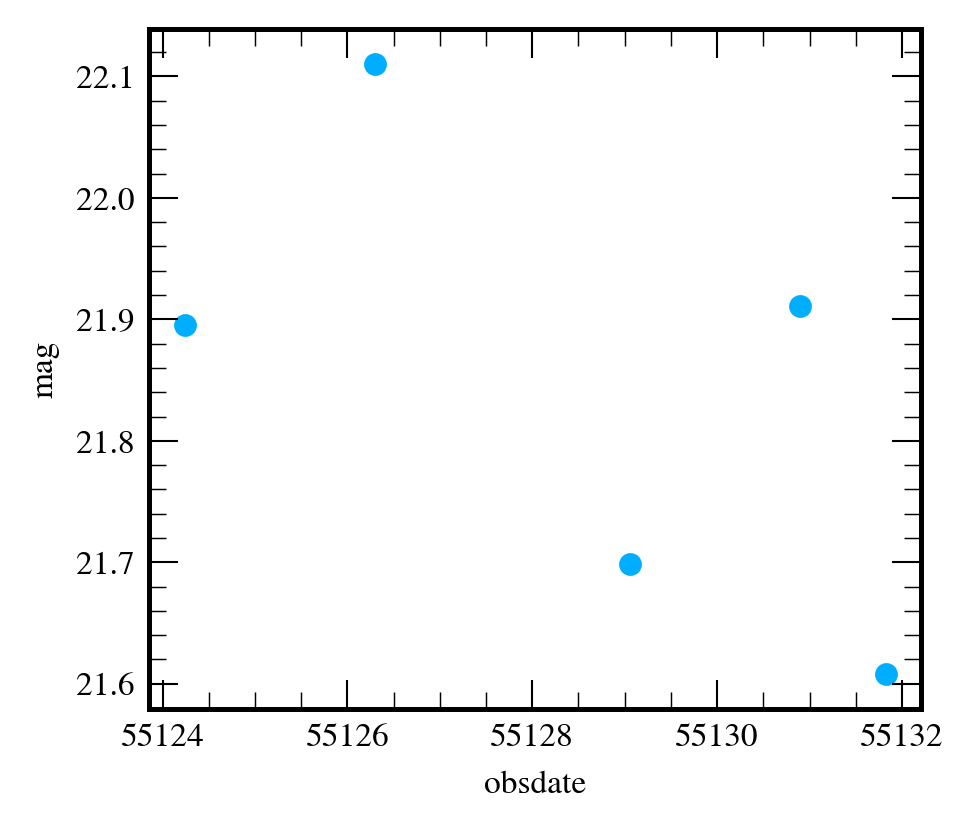

In [33]:
wfc3_broadband_df.loc[5705,'F555W'] .reset_index().plot.scatter(x='obsdate',y='mag')

In [34]:
a=MagMadeMAD[MagMadeMAD.index.get_level_values(1)=='F814W']
b=a[a.MAD/a.eMAD>5]
b.sort_values(by='MAD', ascending=False).droplevel(1)[:10]

,MAG,MAD,eMAD,MAGbin,MedianMAD,MAD_sigma_medmad,MAD_sigma_emag,MAD_sigma
ID,,,,,,,,
3397,20.518588,1.39750,0.025495,20.625,0.01025,136.341463,54.814460,54.814460
5048,21.708338,1.23550,0.024135,21.625,0.01450,85.206897,51.191138,51.191138
17098,22.939838,0.49600,0.059481,22.875,0.02175,22.804598,8.338785,8.338785
15378,22.627338,0.49000,0.050220,22.625,0.01950,25.128205,9.757163,9.757163
19693,24.566338,0.38900,0.046674,24.625,0.04250,9.152941,8.334332,8.334332
20490,23.730338,0.35600,0.034533,23.625,0.02750,12.945455,10.309101,10.309101
3038,17.442338,0.26525,0.021401,17.375,0.01450,18.293103,12.394319,12.394319
10282,22.001338,0.25150,0.021932,22.125,0.01700,14.794118,11.467413,11.467413
16929,23.725338,0.21150,0.035693,23.625,0.02750,7.690909,5.925509,5.925509


In [35]:
wfc3_catalogue.loc[b.sort_values(by='MAD', ascending=False).droplevel(1).index[:10]][['x','y']].to_csv('./WFC3_Broadband/flt_files/F814W/ds9.reg',sep='\t', header=None, index=None)

In [36]:
(33+20+14+8)/23621*100

0.3175140764573896

In [37]:
import csv
for i in range(len(fivesigma_continuum)):
    star=fivesigma_continuum[i][0]
    filter_=fivesigma_continuum[i][1]
    coordinates = all_stars_read.loc[star][['x','y']].values
    filename = './coordfiles/'+str(star)+'_'+filter_+'.fivesigma.coo'
    f = open(filename, 'w')
    with f:
        f.write(str(coordinates[0])+'\t'+str(coordinates[1]))
    f.close()

Length our data 7244
Length marchi 2011 data 14421


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


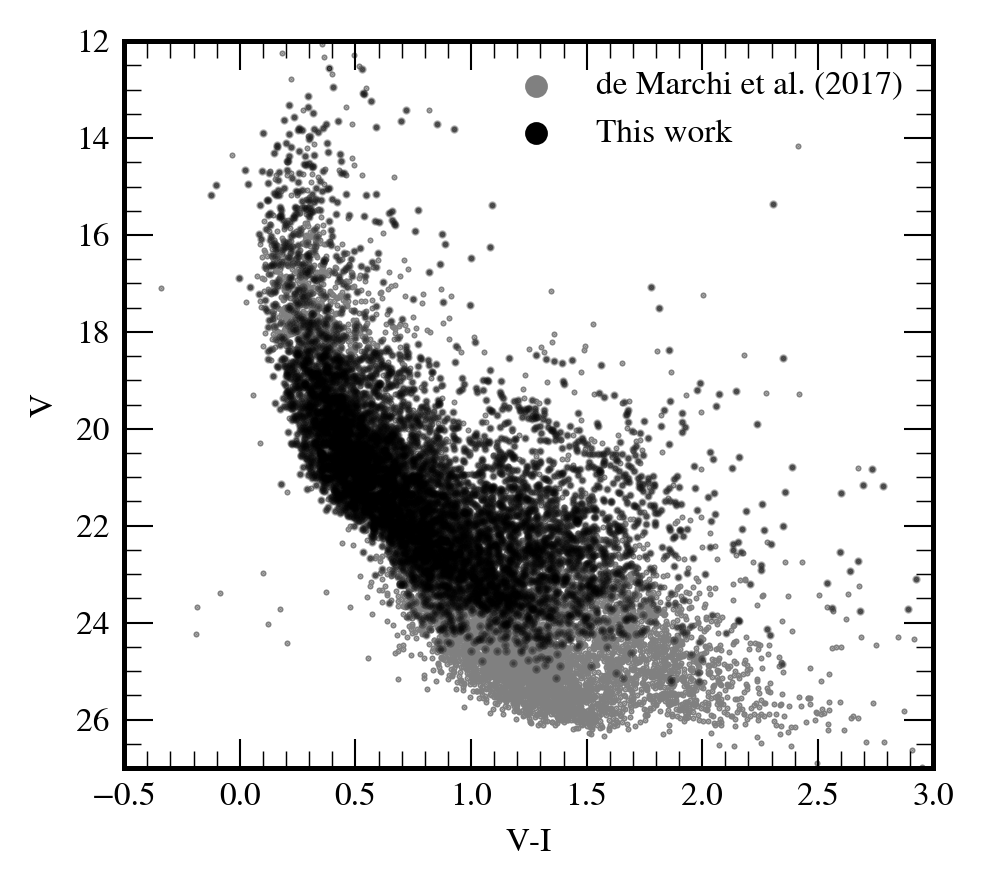

In [38]:
def plot_HR():
    df = pd.DataFrame({'MAG':wfc3_broadband_df.groupby(['ID','Filter'])['mag'].median(),
                       'eMAG':wfc3_broadband_df.groupby(['ID','Filter'])['emag'].mean()})
    
    df = df[df.eMAG<0.07]
    df = df[(df.index.get_level_values(1)=='F555W')+(df.index.get_level_values(1)=='F814W')]
    df = df.unstack().dropna()
    print("Length our data",len(df))
    all_stars_lowerr = all_stars_read[(all_stars_read.ei_2<0.07)&(all_stars_read.ev_2<0.07)]
    print("Length marchi 2011 data",len(all_stars_lowerr))

    this_work = df.index
    VI = all_stars_lowerr.v_1 - all_stars_lowerr.i_1
    V  = all_stars_lowerr.v_1
    
    plt.figure()#figsize=(8,5))
    plt.scatter(all_stars_lowerr.v_1-all_stars_lowerr.i_1, all_stars_lowerr.v_1, color='grey', s=0.2, label='de Marchi et al. (2017)')
    plt.scatter(VI.loc[this_work], V.loc[this_work],s=1, color='black',alpha=0.3)
    #plt.scatter(VI.loc[high_var], V.loc[high_var],s=35, color='red')
    #plt.scatter(VI.loc[Ha_var_IDs], V.loc[Ha_var_IDs],s=14, color='red', label=r'3$\sigma$ variability')
    plt.scatter(VI.loc[this_work].iloc[0], V.loc[this_work].iloc[0],s=0.01, color='black', label='This work')
    #plt.xticks(size=15)
    #plt.yticks(size=15)
    plt.xlabel('V-I')#, size=15)
    plt.ylabel(r'V')#, size=15)
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(27,12)
    lgnd = plt.legend(loc='best',numpoints=1)
    #change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[1]._colors = ['black']
    lgnd.legendHandles[1]._alphas = [1]
    #lgnd.legendHandles[2]._sizes = [10]
    
    plt.tight_layout()
    plt.savefig('VI_V_HR.pdf', dpi=500,bbox_inches='tight')
    return 
plot_HR()

In [39]:
"""plt.figure(figsize=(8,9))
i=1
for filter_ in ['F336W','F438W','F555W', 'F814W']:
    plt.subplot('22'+str(i))
    i+=1
    fMAD =  MAD[MAD.index.get_level_values(1)==filter_]
    fMAD.hist(grid=False,bins=np.arange(-0.05,0.141,0.007), label='All stars', histtype='step', normed=True, linewidth=3, color='gray',linestyle='--')
    fMAD.loc[pms.index].hist(grid=False,bins=np.arange(-0.05,0.141,0.007), label='PMS stars', histtype='step', normed=True, linewidth=3, color='gray')
    plt.title(filter_,size=16, y=0.9,x=0.3)
    if filter_ in ['F555W', 'F814W']:
        plt.xlabel('MAD', size=15)
        plt.xticks([0,0.04,0.08,0.12], size=13)
    else:
        plt.xticks([])
    #plt.ylabel('Normalized frequency', size=15)
    plt.legend(fontsize=14)
    plt.xlim(0,0.15)
    plt.grid(b=False)
    plt.yticks([])
#plt.suptitle('Variability of PMS and other stars', size=17)
plt.tight_layout(pad=-2)
plt.savefig('MAD_PMS_noPMS_broadband.pdf', dpi=500, bbox_inches='tight')
plt.show()"""

"plt.figure(figsize=(8,9))\ni=1\nfor filter_ in ['F336W','F438W','F555W', 'F814W']:\n    plt.subplot('22'+str(i))\n    i+=1\n    fMAD =  MAD[MAD.index.get_level_values(1)==filter_]\n    fMAD.hist(grid=False,bins=np.arange(-0.05,0.141,0.007), label='All stars', histtype='step', normed=True, linewidth=3, color='gray',linestyle='--')\n    fMAD.loc[pms.index].hist(grid=False,bins=np.arange(-0.05,0.141,0.007), label='PMS stars', histtype='step', normed=True, linewidth=3, color='gray')\n    plt.title(filter_,size=16, y=0.9,x=0.3)\n    if filter_ in ['F555W', 'F814W']:\n        plt.xlabel('MAD', size=15)\n        plt.xticks([0,0.04,0.08,0.12], size=13)\n    else:\n        plt.xticks([])\n    #plt.ylabel('Normalized frequency', size=15)\n    plt.legend(fontsize=14)\n    plt.xlim(0,0.15)\n    plt.grid(b=False)\n    plt.yticks([])\n#plt.suptitle('Variability of PMS and other stars', size=17)\nplt.tight_layout(pad=-2)\nplt.savefig('MAD_PMS_noPMS_broadband.pdf', dpi=500, bbox_inches='tight')\nplt.

/home/luuk/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


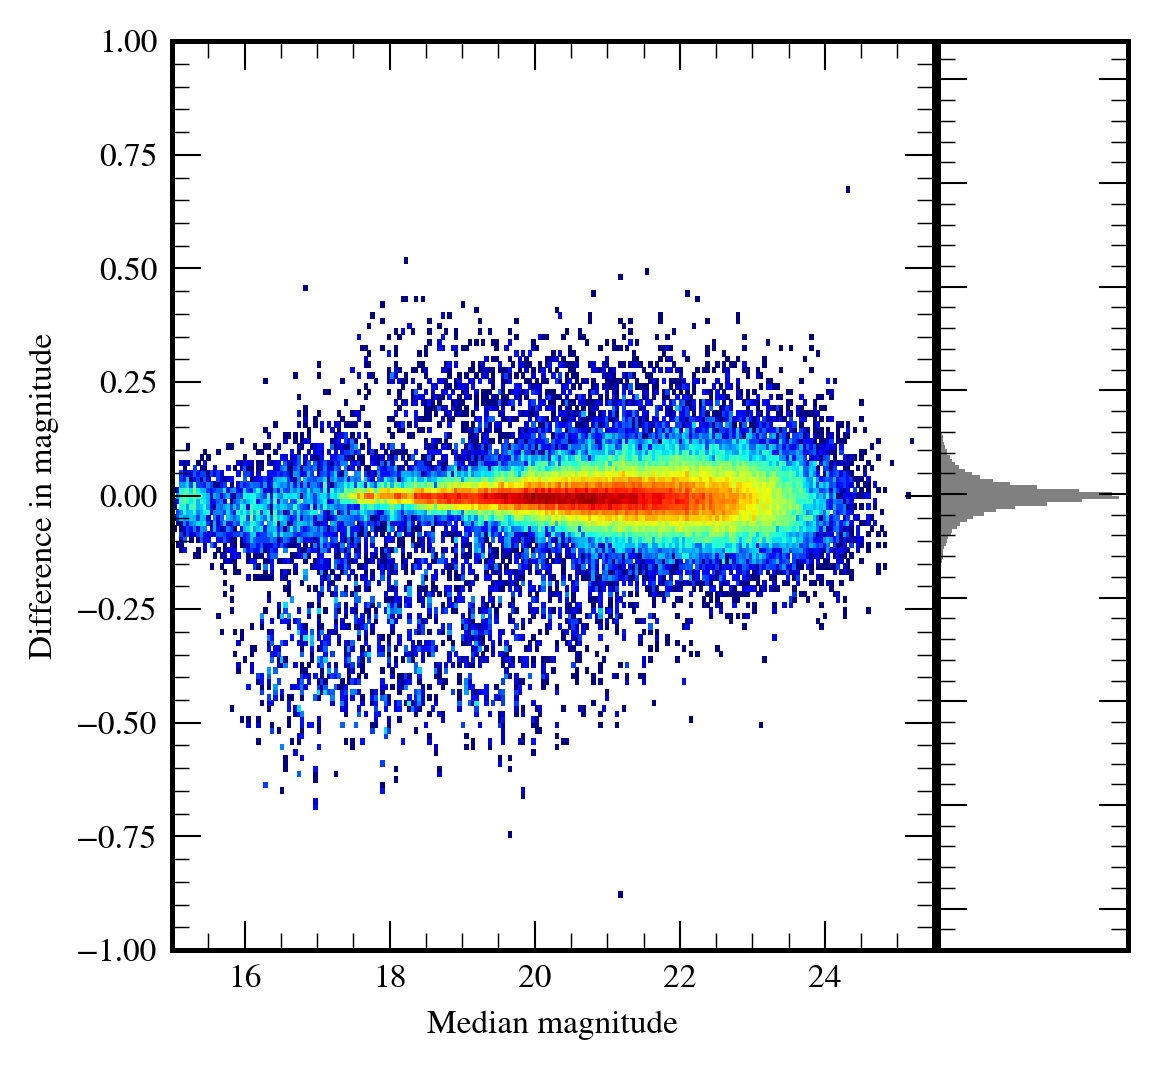

In [40]:
def Trumpet(phot_df):
    magcol='mag'
    IDcol='ID'
    merrcol = 'emag'
    # Trumpet plot
    
    magnitudes = phot_df[magcol]
    filters = magnitudes.index.get_level_values(1).unique()
    num=0
    fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]})#,figsize=(8.5,4.5))

    #plt.subplot(1,2,1,gridspec_kw={'width_ratios': [3, 1]})
    xs, ys = np.array([]), np.array([])
    for filter_ in np.sort(filters):
        epochs  = magnitudes.loc[:,filter_,:].index.get_level_values(1).unique()
        mags_t0 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[0], :])
        num+=1
        for i in range(len(epochs)-1):
            mags_t1 = pd.DataFrame(magnitudes.loc[:, filter_, epochs[i+1], :])
            join_mags = mags_t0.join(mags_t1, lsuffix = '_t0', rsuffix='_t1', how='inner')
            join_mags['DeltaMag'] = join_mags[magcol+'_t1'] - join_mags[magcol+'_t0']
            median_mags = magnitudes.loc[:, filter_, :].groupby([IDcol]).median()
            join_mags = join_mags.join(median_mags)
            x, y = join_mags[magcol].values, join_mags['DeltaMag'].values
            x, y = x[np.isfinite(x)*np.isfinite(y)], y[np.isfinite(x)*np.isfinite(y)]
            xs = np.hstack((xs,x))
            ys = np.hstack((ys,y))
    a0.hist2d(xs, ys, bins=(np.linspace(14,25.5,250), np.linspace(-3,3,500)), cmap='jet', cmin=2, norm=LogNorm())
    a0.set_ylabel('Difference in magnitude')#, size=15)
    a0.set_xlabel('Median magnitude')#, size=15)
    a0.set_xlim(15,25.5)
    a0.set_ylim(-1,1)
    fig.tight_layout(pad=-1.65)
    #a0.set_xticks(fontsize=15)
    #a0.tick_params(labelsize=15)
    #a0.set_yticks(fontsize=15)
    a1.hist(ys, bins=np.arange(-1,1,0.0081),orientation="horizontal", color='gray')
    a1.set_yticks(ticks=np.arange(-1,1.01,0.25))
    a1.set_yticklabels(len(np.arange(-1,1.01,0.25))*[''])
    a1.set_xticks([])
    plt.savefig('trumpet_diagram.pdf', dpi=500, bbox_inches='tight')
    plt.show()
Trumpet(wfc3_broadband_df)

<h4>Broadband plot</h4>


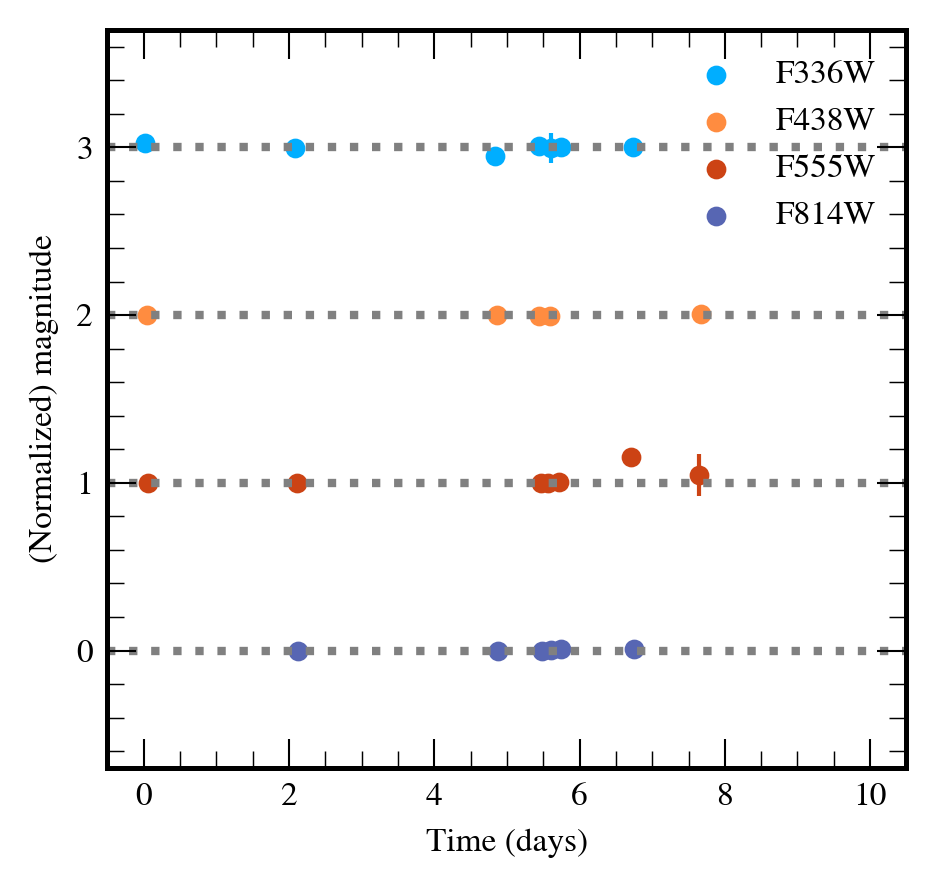

In [82]:
def plot_timeseries(AssocID=2414, save=False):
    plt.figure()#igsize=(8,5))
    Filter=['F336W','F438W','F555W','F814W', 'F656N']
    Filters = Filter
    filter_i = 0
    for Filter in Filters:
        
        """if Filter=='F656N':
            try:
                a = pd.read_pickle('../ResearchProject2/IRAF/Joined_BroadbandDRZ_singleHa.pickle')
                JulianDates = a.loc[AssocID, Filter].reset_index().T_Start.values
                Magnitudes  = a.loc[AssocID, Filter].MAG
                #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
                MAG_err     = a.loc[AssocID, Filter].MERR
                Magnitudes  = Magnitudes - np.median(Magnitudes)-filter_i+4
                plt.axhline(filter_i,xmin=0,xmax=0.75, ls='dotted', color='grey')
                filter_i+=1
                JulianDates = JulianDates - 55124.18571567
                plt.errorbar(JulianDates, Magnitudes, yerr=2*MAG_err, linestyle='none', lw=1)
                plt.scatter(JulianDates, Magnitudes,s=14, label=Filter)
            except:
                pass"""
        
        try:
            JulianDates = wfc3_broadband_df.loc[AssocID, Filter].reset_index().obsdate
            Magnitudes  = wfc3_broadband_df.loc[AssocID, Filter].mag
            #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
            MAG_err     = wfc3_broadband_df.loc[AssocID, Filter].emag
            Magnitudes  = Magnitudes - np.median(Magnitudes)-filter_i+3
            plt.axhline(filter_i,xmin=0,xmax=1, ls='dotted', color='grey')
            filter_i+=1
            JulianDates = JulianDates - 55124.18571567
            plt.errorbar(JulianDates, Magnitudes, yerr=2*MAG_err, linestyle='none', lw=1)
            plt.scatter(JulianDates, Magnitudes,s=14, label=Filter)
        except:
            pass
        
    plt.xlim(-0.5,10.5)
    plt.ylim(-0.7,3.7)
    plt.legend(loc='upper right')
    plt.ylabel('(Normalized) magnitude')
    plt.xlabel('Time (days)')
    plt.tight_layout()
    plt.yticks([0,1,2,3])
    #plt.scatter(JulianDates, Magnitudes, marker='o', c='black')
    if save:
        plt.savefig('example_timeseries.pdf', dpi=500, bbox_inches='tight')
    plt.show()
plot_timeseries(save=True)

<h3>WFC3 Ha</h3>

Int64Index([1169, 1324, 2803, 6360, 7933], dtype='int64', name='AssocID')


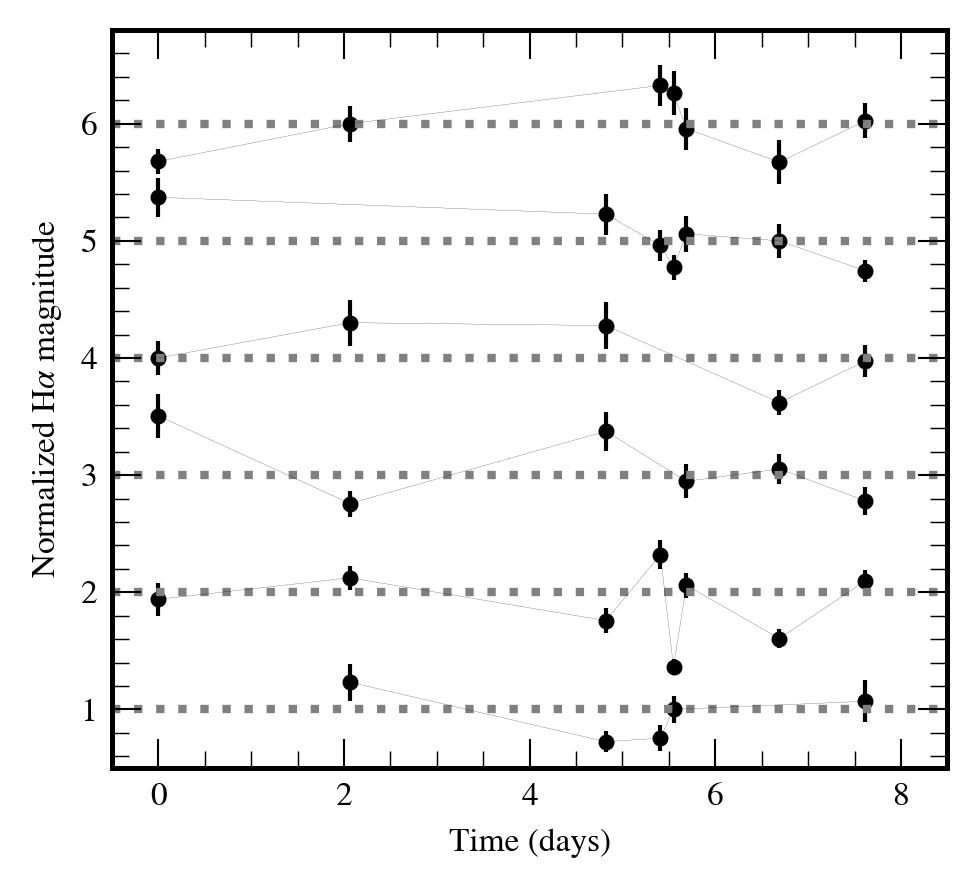

In [92]:
def plot_ha_timeseries(save=False):
    
    #wfc3_ha_df = pd.read_pickle('../ResearchProject2/IRAF/Joined_BroadbandDRZ_singleHa.pickle')
    #wfc3_ha_df = wfc3_ha_df[wfc3_ha_df.index.get_level_values(1)=='F656N']

    #toplot = wfc3_ha_df
    #print(toplot)
    """
    three_con = wfc3_ha_df[(wfc3_ha_df.index.get_level_values(2)>55129.3) * (wfc3_ha_df.index.get_level_values(2)<55130)]
    three_con = pd.DataFrame({'STDerror':three_con.groupby(['AssocID','Filter'])['MAG'].std().dropna()})
    wfc3_ha_df = pd.merge(wfc3_ha_df,three_con, left_index=True,right_index=True, how='left')

    wfc3_ha_df = wfc3_ha_df[~wfc3_ha_df.STDerror.isna()]

    nmeas = wfc3_ha_df.groupby('AssocID')['MAG'].nunique()>4
    nmeas = nmeas.index[nmeas]

    wfc3_ha_df = wfc3_ha_df.loc[nmeas]

    wfc3_ha_df['eMAG'] = np.sqrt(wfc3_ha_df['STDerror']**2+wfc3_ha_df['MERR']**2)
    
    minmax = (wfc3_ha_df.groupby('AssocID')['MAG'].max() - wfc3_ha_df.groupby('AssocID')['MAG'].min()) 
    minmax_sigma = minmax / wfc3_ha_df.groupby('AssocID')['eMAG'].median()
    mag = wfc3_ha_df.loc[minmax.index].groupby('AssocID')['MAG'].median()
    mad = np.abs(wfc3_ha_df.groupby(['AssocID','T_Start'])['MAG'].median()-wfc3_ha_df.groupby(['AssocID'])['MAG'].median()).groupby('AssocID').median()

    variable = (minmax_sigma>5)*(minmax>0.4)*(mad>0.05)

    toplot = wfc3_ha_df.loc[variable.index[variable]]

    nmeas = toplot.groupby('AssocID')['MAG'].nunique()>6
    nmeas = nmeas.index[nmeas]

    wfc3_ha_x = toplot.loc[nmeas]
    """
    toplot = wfc3_ha_df.loc[wfc3_ha_x]
    plt.figure()#figsize=(8,6))
    stars = toplot.index.get_level_values(0).unique()[:5]
    star_i = 1
    print(stars)
    stars = wfc3_ha_x#[2414, 3347, 5938, 3848, 3554, 8593]
    for star in stars:
        JulianDates = toplot.loc[star].reset_index()['T_Start']
        Magnitudes  = toplot.loc[star].MAG
        #Synth_err   = self.phot_df.loc[AssocID, Filter].SynErrorDevSig
        MAG_err     = toplot.loc[star].MERR
        Magnitudes  = Magnitudes - np.median(Magnitudes)+star_i
        plt.axhline(star_i,xmin=0,xmax=1, ls='dotted', color='grey')
        star_i+=1
        JulianDates = JulianDates - 55124.18571567
        plt.errorbar(JulianDates, Magnitudes, yerr=MAG_err, linestyle='none',lw=1, color='black')# label=Filter)
        plt.scatter(JulianDates, Magnitudes, s=8, color='black')# label=Filter)
        plt.plot(JulianDates, Magnitudes,lw=0.05, color='black')# label=Filter)

        
    #plt.legend(loc='center', fontsize=15)
    plt.ylabel(r'Normalized H$\alpha$ magnitude')
    plt.xlabel('Time (days)')
    plt.tight_layout()
    plt.xlim(-0.5,8.5)
    plt.ylim(-0.7,5)
    plt.yticks(np.arange(1,len(stars)+1))
    plt.ylim(0.5,len(stars)+0.8)
    if save:
        plt.savefig('WFC3_Ha_variability.pdf', dpi=500, bbox_inches='tight')
    plt.show()
plot_ha_timeseries(save=True)

In [102]:
wfc3_ha_df = pd.read_pickle('../ResearchProject2/IRAF/Joined_BroadbandDRZ_singleHa.pickle')
wfc3_ha_df = wfc3_ha_df[wfc3_ha_df.index.get_level_values(1)=='F656N']
wfc3_ha_df = wfc3_ha_df[wfc3_ha_df.MERR<0.2]

In [29]:
a=wfc3_ha_df.groupby('AssocID')['MAG'].nunique()>4
a=a.index[a]
wfc3_ha_df = wfc3_ha_df.loc[a]
print(len(wfc3_ha_df))
print(wfc3_ha_df.index.get_level_values(0).nunique())

27839
3679


/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


4543
14


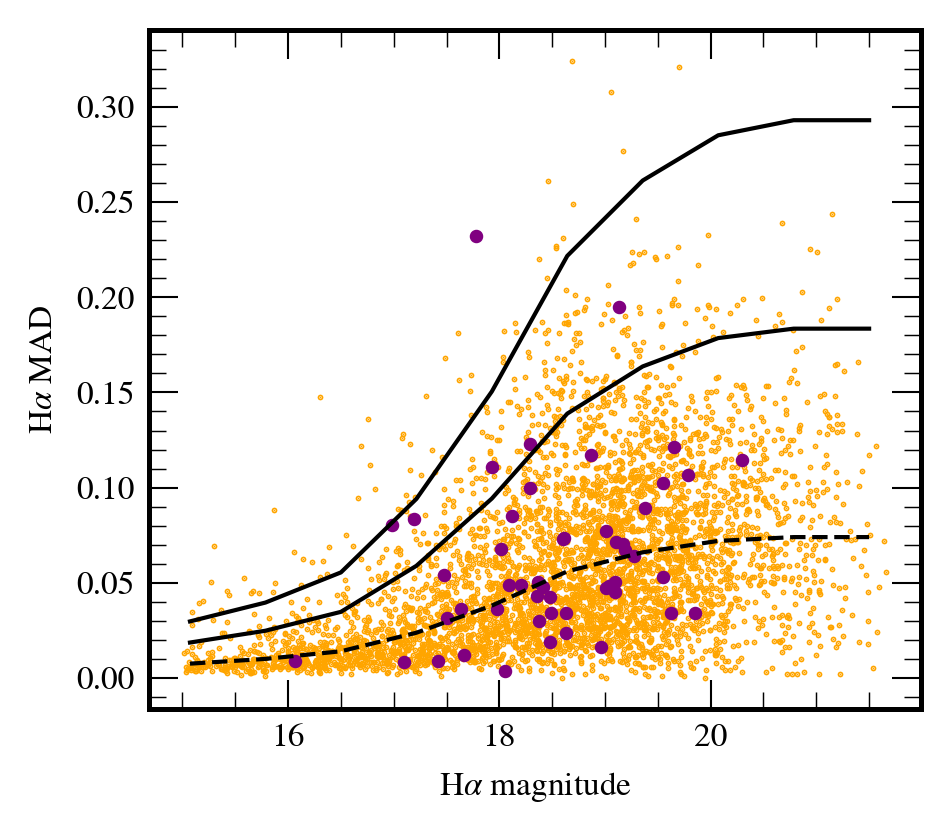

In [103]:
plt.figure()
mad1=(wfc3_ha_df.reset_index().groupby(['AssocID','T_Start'])['MAG'].median()-wfc3_ha_df.groupby('AssocID')['MAG'].median()).abs()
mad=mad1.reset_index().groupby('AssocID')['MAG'].median()
mag = wfc3_ha_df.groupby('AssocID')['MAG'].median()
#plt.scatter(mag, mad,s=0.01,edgecolor='red',facecolor='red')

total_bins = 15
bins = np.linspace(14,24, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(mag,bins)
running_median = np.array([np.median(mad[idx==k]) for k in range(total_bins)])
all_y_interp = interp_func(mag,bins, delta, running_median)
two_sigma_above = all_y_interp +2*1.48*all_y_interp#+ 1.5*1.48*all_y_interp

x = (mad>two_sigma_above)*(mag>14)*(mad>0.182)
x = x[x].index
print(len(mag))
print(len(x))
plt.scatter(mag, mad, edgecolor='orange',s=0.15,marker='o',facecolor='orange')
#plt.scatter(mag.loc[x], mad.loc[x], edgecolor='red',s=0.4,marker='o',facecolor='red')
plt.scatter(mag.loc[[w[0] for w in continuum_variables if w[1]=='F555W']], mad.loc[[w[0] for w in continuum_variables if w[1]=='F555W']], edgecolor='purple',s=5,marker='o',facecolor='purple')

plt.plot(bins-delta/2, running_median, color='black', lw=1,linestyle='--')
plt.plot(bins-delta/2, running_median*(1+1*1.48), color='black', lw=1)
plt.plot(bins-delta/2, running_median*(1+2*1.48), color='black', lw=1)
plt.xlabel(r'H$\alpha$ magnitude')
plt.ylabel(r'H$\alpha$ MAD')

plt.savefig('Ha_WFC3_MAD_Vvariables.pdf')
wfc3_ha_x = x

In [62]:
wfc3_ha_x

Int64Index([1169, 2803, 6360, 7933, 8645], dtype='int64', name='AssocID')

In [46]:
b=wfc3_ha_df.loc[x]#.to_excel('Ha_vars.xlsx')
b['dMAG'] = b['MAG'] - b.groupby(['AssocID','Filter']).MAG.median()
b[['MAG','MERR','dMAG']].to_excel('Ha_vars.xlsx')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
a=wfc3_broadband_df.loc[x]
a['dMAG'] = a['mag'] - a.groupby(['ID', 'Filter']).mag.median()
a.to_excel('cont_vars.xlsx')

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


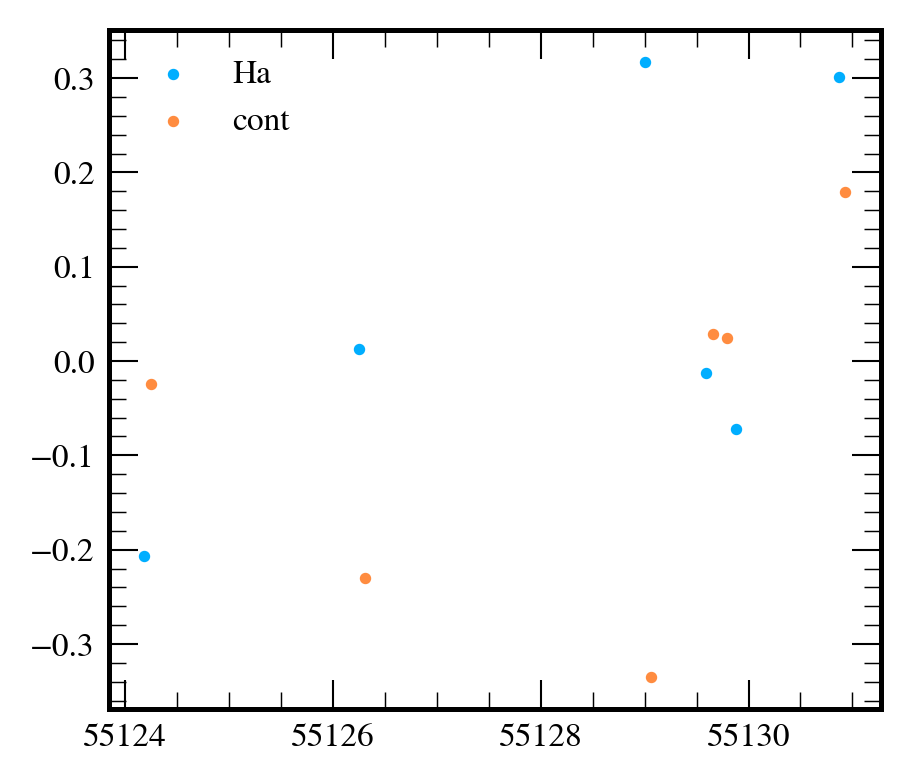

In [48]:
fig=plt.figure()
cx = b.loc[1015].reset_index()['T_Start']
cy = b.loc[1015].reset_index()['dMAG']


dx = a.loc[1015].reset_index()['obsdate']
dy = a.loc[1015].reset_index()['dMAG']

plt.scatter(cx, cy,s=3,label='Ha')
plt.scatter(dx,dy,s=3,label='cont')
plt.legend()

In [49]:
haband = b[['MAG','MERR','dMAG']]
haband.columns = ['mag','emag','dMAG']
broadband = a[['mag','emag','dMAG']]
broadband.columns = ['mag','emag','dMAG']

broadband = broadband.loc[haband.index.get_level_values(0)]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


Text(0, 0.5, 'Deviation in Ha')

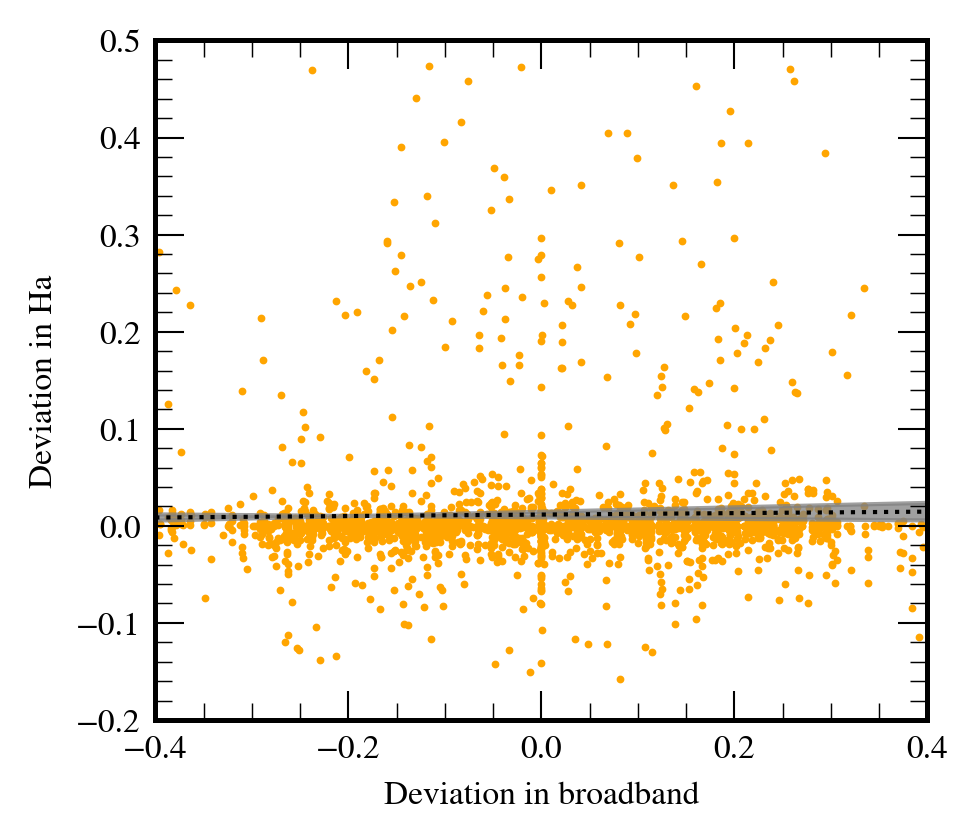

In [50]:
offsets_Ha = []
offsets_broadband = []

for ID in broadband.index.get_level_values(0).unique():
    Ha_data = haband.loc[ID].reset_index()
    Ha_data_x = Ha_data.T_Start.values # Get time / x-axis for Ha data for star "ID"  (is array)
    Ha_data_y = Ha_data.dMAG.values    # Get magnitude offsets for this star (is array)
    
    cdict = {'F814W':'red','F555W':'green','F438W':'blue','F336W':'purple'}
    
    filters = broadband.loc[ID].index.get_level_values(0).unique() # Check all filters FxxxW available for this star
    for filt in filters: # Loop through these filters
        broadband_data = broadband.loc[ID,filt].reset_index() 
        broadband_data_x = broadband_data.obsdate.values# Get time for measurements (is array)
        broadband_data_y = broadband_data.dMAG.values# Get magnitude offsets for this star(is an array)
        
        # Find closest measurement
        for i in range(0,len(broadband_data_x)): # Loop through measurements in broadband (FxxxW)
            t_b = broadband_data_x[i] 
            argmin = np.argmin(np.abs(Ha_data_x-t_b)) # Find index of closest measuremetn in Ha (based on absolute time difference <-> eng 55124-5514.1)
            valmin = np.min(np.abs(Ha_data_x-t_b)) # Get the actual time difference
            
            if valmin<0.2: # within 24*0.2 = 4.8 hours?
                
                offsets_Ha.append(Ha_data_y[argmin]) 
                offsets_broadband.append(broadband_data_y[i])
                #plt.scatter(broadband_data_y[i],Ha_data_y[argmin],s=1,color=cdict[filt],alpha=0.2)
                # plot on x the broadband value for dMAG and on y the Ha value for dMAG
            
plt.scatter(offsets_Ha,offsets_broadband,s=3,color='orange',marker='.')
plt.ylim(-0.2,0.5)
plt.xlim(-0.4,0.4)

from scipy.optimize import curve_fit
def func(x,a,b):
    return a*x+b
popt,pcov = curve_fit(func,offsets_Ha,offsets_broadband)

xnew=np.arange(-0.4,0.8,0.1)
plt.plot(xnew,func(xnew,*popt),color='black',lw=1,ls='dotted')
plt.fill_between(xnew,func(xnew,*(popt-1.96*np.diag(np.sqrt(pcov)))),func(xnew,*(popt+1.96*np.diag(np.sqrt(pcov)))),color='grey',alpha=0.75)
plt.xlabel('Deviation in broadband')
plt.ylabel('Deviation in Ha')

<h3>Observations Table</h3>

In [51]:
def make_table():
    flt_list = glob('./WFC3_Broadband/flt_files/F*W/*_flt.fits')
    acs_list  =glob('./ACS_Ha/flc_files/OrIg_files/*_flc.fits')
    acs_br_list = glob('./ACS_Broadband/flc_files/F*/OrIg_files/*fl*fits')
    flt_list = np.hstack((flt_list,acs_list,acs_br_list))
    filters = []
    names = []
    obstimes = []
    instrument = []
    exptimes = []
    pointing = []
    for f in flt_list:
        hdu = fits.open(f)
        header = hdu[0].header
        names.append(header['ROOTNAME'])#['OBS-START']
        obstimes.append(header['DATE-OBS']+ ' ' +header['TIME-OBS'])
        exptimes.append(header['EXPTIME'])
        pointing.append(str(header['RA_TARG']) + ' '+ str(header['DEC_TARG']))
        try:
            filters.append(str(header['FILTER']))
        except:
            filters.append(str(header['FILTER1']))
        instrument.append(header['INSTRUME'])
    df = pd.DataFrame({'Instrument':instrument,'Name':names, 'Filter':filters, 'Exposure start':obstimes, 'Exposure time':exptimes, 'Pointing':pointing})
    
    df['Exposure start'] = pd.to_datetime(df['Exposure start'])
    df = df.sort_values(by='Exposure start')
    
    ACS_df = df[df.Instrument=='ACS']
    WFC_df = df[df.Instrument=='WFC3']
    ACS_df['Time difference'] = ACS_df['Exposure start'] - ACS_df['Exposure start'].iloc[0]
    WFC_df['Time difference'] = WFC_df['Exposure start'] - WFC_df['Exposure start'].iloc[0]
    df = pd.concat((WFC_df, ACS_df))
    df = df.sort_values(by='Exposure start')
    df = df[df['Exposure time']>0]
    return df[['Instrument', 'Name', 'Filter', 'Exposure time', 'Exposure start', 'Time difference']]
print(make_table().to_latex(index=False))

\begin{tabular}{lllrlr}
\toprule
Instrument &       Name & Filter &  Exposure time &      Exposure start &   Time difference \\
\midrule
      WFC3 &  ib6wd1roq &  F336W &          400.0 & 2009-10-20 04:18:23 &   0 days 00:00:00 \\
      WFC3 &  ib6wd1rxq &  F438W &          440.0 & 2009-10-20 04:52:30 &   0 days 00:34:07 \\
      WFC3 &  ib6wd1s1q &  F555W &          435.0 & 2009-10-20 05:02:21 &   0 days 00:43:58 \\
      WFC3 &  ib6wd1sdq &  F336W &          430.0 & 2009-10-20 05:37:47 &   0 days 01:19:24 \\
      WFC3 &  ib6wd1sgq &  F814W &          664.0 & 2009-10-20 05:47:25 &   0 days 01:29:02 \\
      WFC3 &  ib6wd1siq &  F814W &          664.0 & 2009-10-20 06:00:37 &   0 days 01:42:14 \\
      WFC3 &  ib6wd1smq &  F438W &          440.0 & 2009-10-20 06:14:15 &   0 days 01:55:52 \\
      WFC3 &  ib6wd1sqq &  F555W &          435.0 & 2009-10-20 06:24:06 &   0 days 02:05:43 \\
      WFC3 &  ib6wd4ksq &  F336W &          430.0 & 2009-10-22 05:49:03 &   2 days 01:30:40 \\
      WF

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<h3> ACS Broadband </h3>

In [52]:
ACS_broadband_df = pd.read_pickle('./ACS_Broadband/ACS_Broadband.pickle')
to_keep = ((ACS_broadband_df.groupby(['ID','Filter'])['mag'].max() - ACS_broadband_df.groupby(['ID','Filter'])['mag'].min())<0.3)
ACS_broadband_df = ACS_broadband_df.groupby(['ID','Filter']).median()#to_keep.index[to_keep]
ACS_broadband_df = ACS_broadband_df.loc[to_keep]
ACS_broadband_df = ACS_broadband_df.unstack()
ACS_broadband_df = ACS_broadband_df.dropna()
ACS_broadband_df.head(3)


mag                 emag          
Filter      F555W      F775W     F555W     F775W
ID                                              
267     16.252654  16.547811  0.021920  0.064347
278     16.941154  16.747311  0.188259  0.189817
281     16.918154  16.589311  0.193194  0.192333

<h3> ACS Ha </h3>

In [53]:
ACS_Ha_df = pd.read_pickle('./ACS_Ha/ACS_Ha.pickle')
ACS_Ha_max = ACS_Ha_df.groupby('ID')['mag'].min()
ACS_Ha_idxmax = ACS_Ha_df.groupby('ID')['mag'].idxmin()
ACS_Ha_emax = ACS_Ha_df.loc[ACS_Ha_idxmax]['emag'].groupby('ID').median()

ACS_Ha_min = ACS_Ha_df.groupby('ID')['mag'].max()
ACS_Ha_idxmin = ACS_Ha_df.groupby('ID')['mag'].idxmax()
ACS_Ha_emin = ACS_Ha_df.loc[ACS_Ha_idxmin]['emag'].groupby('ID').median()

<h3>Combine ACS DFs</h3>

In [54]:
ACS_df = pd.DataFrame({'m555':ACS_broadband_df['mag']['F555W'],'e555':ACS_broadband_df['emag']['F555W'],
                       'm75':ACS_broadband_df['mag']['F775W'],'e75':ACS_broadband_df['emag']['F775W'],
                       'm658max':ACS_Ha_max,'e658max':ACS_Ha_emax,'m658min':ACS_Ha_min,'e658min':ACS_Ha_emin})
ACS_df['m658'] = -2.5*np.log10(1/2*(10**(ACS_df.m658max/-2.5)+10**(ACS_df.m658min/-2.5)))
ACS_df = ACS_df.dropna()
ACS_df = ACS_df[ACS_df.e658max<0.1]
ACS_df = ACS_df[ACS_df.e658min<0.1]
ACS_df = ACS_df[ACS_df.e555<0.1]
ACS_df = ACS_df[ACS_df.e75<0.1]
ACS_df.e658max /=2
ACS_df.e658min /=2
len(ACS_df)

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


1250

<h3>Compute Ha line variation</h3>

In [55]:
#ACS_df = ACS_df[(ACS_df.e_delta_Ha<10)&(ACS_df.delta_Ha>0.01)]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


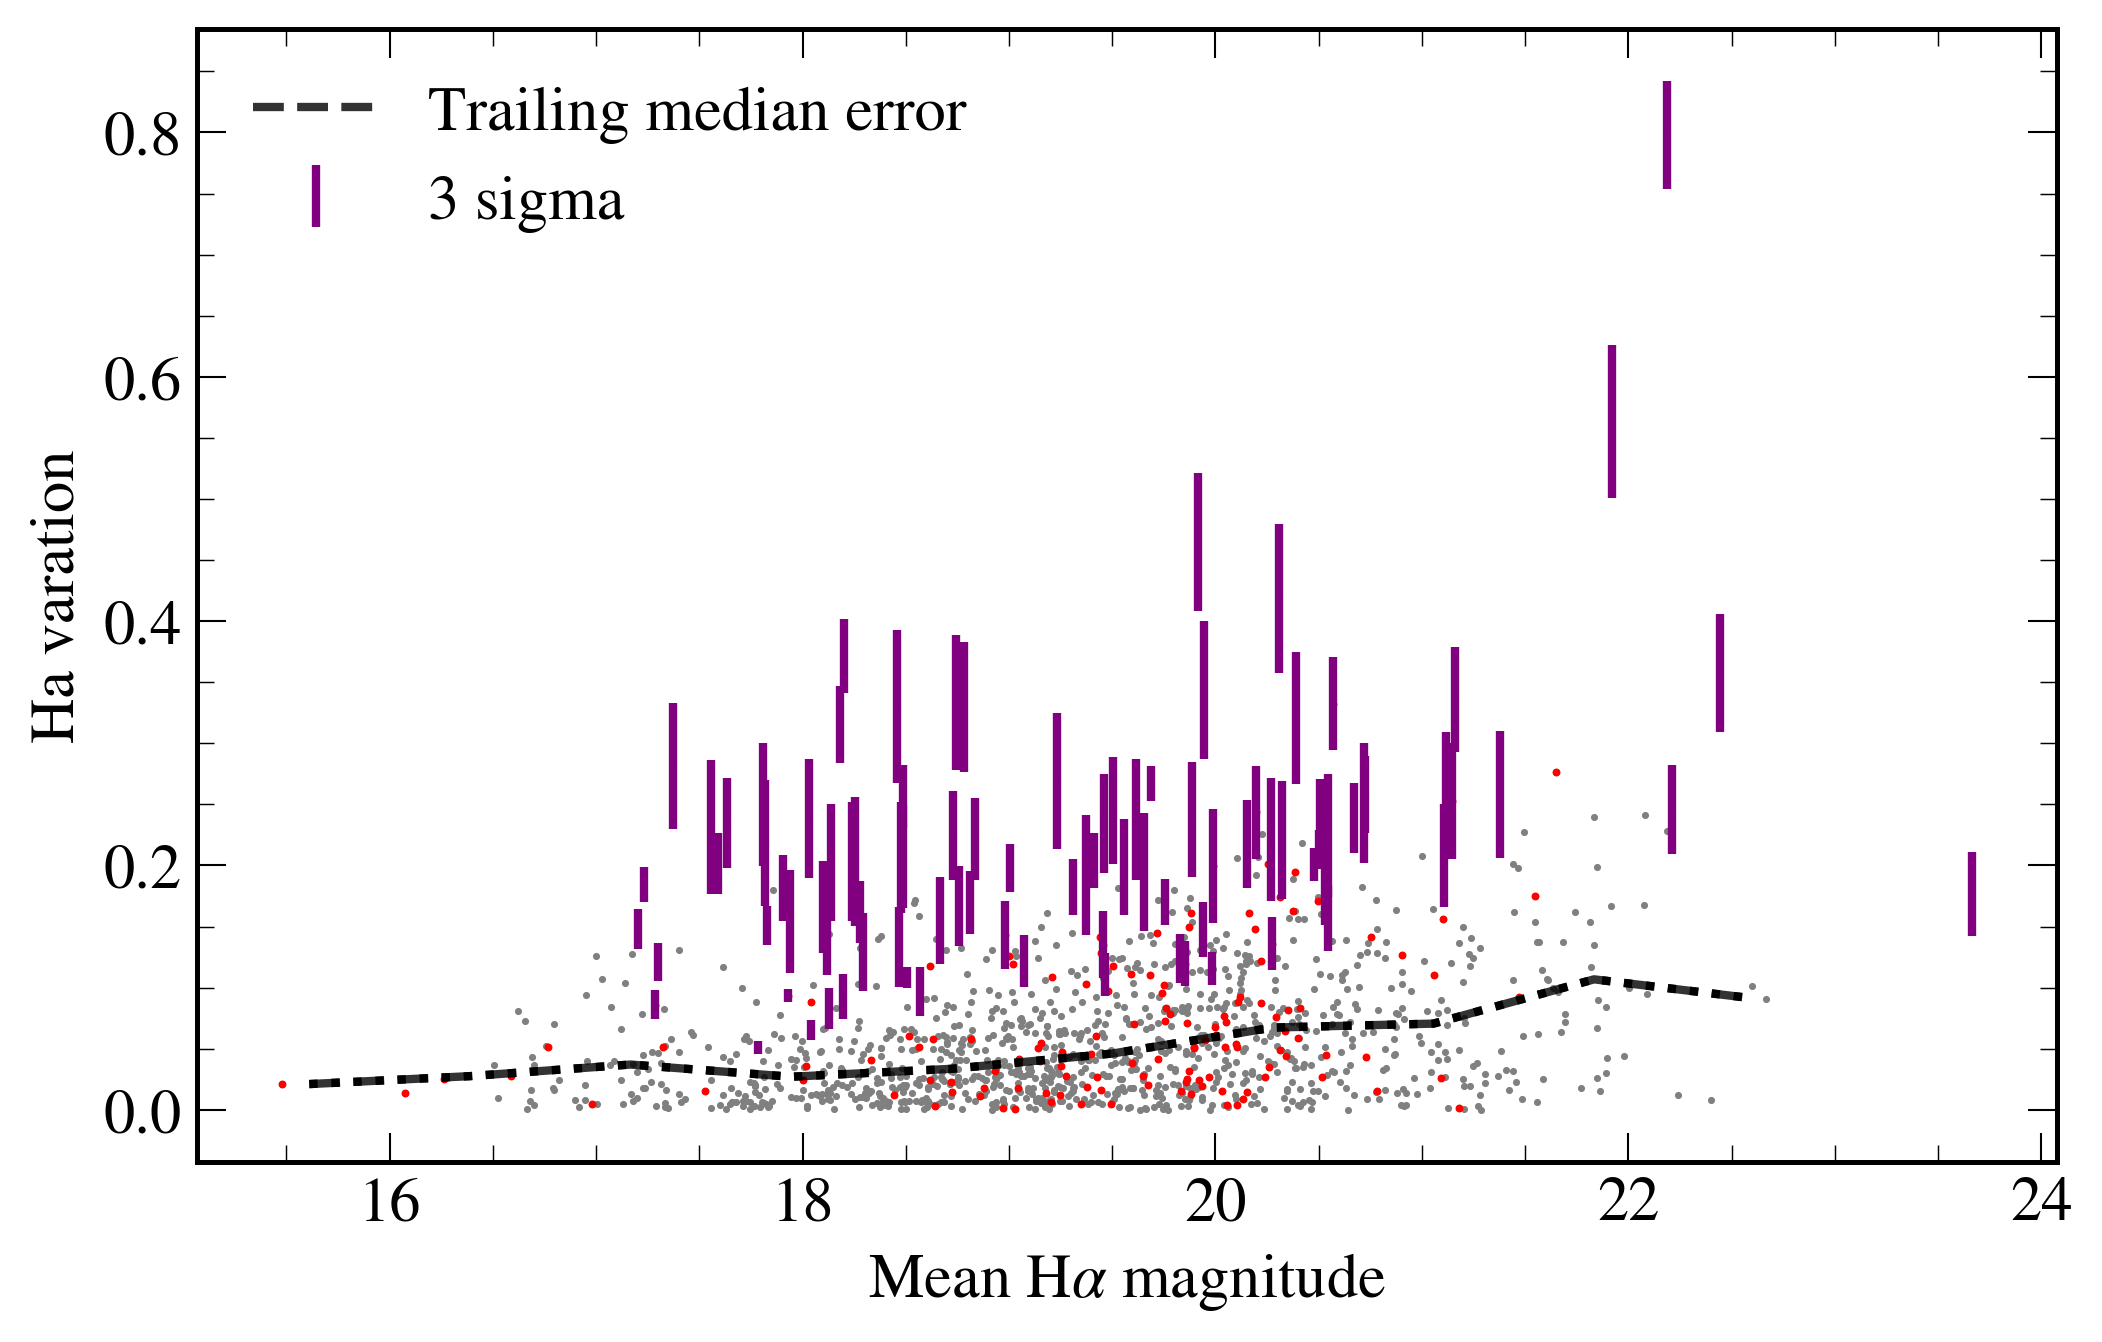

In [56]:
X = ACS_df.m658
Y = ACS_df.m658min - ACS_df.m658max
E = np.sqrt(ACS_df.e658max**2+ACS_df.e658min**2)

total_bins = 10
bins = np.linspace(16,23, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = np.array([np.median(Y[idx==k]) for k in range(total_bins)])

Y_interp = interp_func(X,bins, delta, running_median)


plt.figure(figsize=(8,5))
plt.scatter(X, Y,s=0.5, color='grey')
plt.scatter(X.loc[pms_ids],Y.loc[pms_ids], color='red',s=0.8)
fivesigma = (Y - Y_interp)/E>3
plt.errorbar(X[fivesigma], Y[fivesigma], E[fivesigma], ls='none', color='purple', label='3 sigma')
plt.plot(bins-delta/2, running_median, color='black', ls='dotted')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel(r'Mean H$\alpha$ magnitude', size=15)
plt.ylabel(r'Ha varation', size=15)
plt.plot(bins-delta/2,running_median,color='black', linestyle='dashed',lw=2,alpha=.8, label='Trailing median error')
plt.legend(loc='upper left', fontsize=15)

In [57]:
"""def process_ACSHa(df):
    """X = ACS_df.m658
    Y = ACS_df.m658max - ACS_df.m658min
    E = np.sqrt(ACS_df.e658max**2+ACS_df.e658min**2)

    total_bins = 10
    bins = np.linspace(16,23, total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    running_median = np.array([np.median(Y[idx==k]) for k in range(total_bins)])

    Y_interp = interp_func(X,bins, delta, running_median)
    """
    # Define arrays
    Hamin = df.m658max
    Hamax = df.m658min
    Hamean = df.m658
    Hamean_err = 0.5*(df.e658min+df.e658max)
    # Get average magnitude using minimum and maximum magnitude
    avgHamag = -2.5*np.log10(1/3*(10**(df.m658max/-2.5)+10**(df.m658/-2.5)+10**(df.m658min/-2.5)))
    # Take the V-I color 
    VI       = (df.m555 - df.m75)
    # V-Ha color predicted for no-excess
    # Derive Ha excess in min and max regime
    VHa_nex     = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
    interp_Ha   = df.m555 - VHa_nex
    Ha_HaC_max  = Hamax   - interp_Ha
    Ha_HaC_min  = Hamin   - interp_Ha
    Ha_HaC_mean = Hamean  - interp_Ha
    # Derive equivalent widths
    RW = 74.96
    WEQ_max  = RW * (1-10**(-0.4*Ha_HaC_max))
    WEQ_min  = RW * (1-10**(-0.4*Ha_HaC_min))
    WEQ_mean = RW * (1-10**(-0.4*Ha_HaC_mean))

    delta_WEQ = WEQ_max - WEQ_min
    sigma_Ha_Hac_min  = np.sqrt(df.e658min**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    sigma_Ha_Hac_max  = np.sqrt(df.e658max**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    sigma_Ha_Hac_mean = np.sqrt(Hamean_err**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    eWEQ_min = RW*0.4*np.log(10)*10**(-0.4*Ha_HaC_min) * sigma_Ha_Hac_min
    eWEQ_max = RW*0.4*np.log(10)*10**(-0.4*Ha_HaC_max) * sigma_Ha_Hac_max
    eWEQ_mean = RW*0.4*np.log(10)*10**(-0.4*Ha_HaC_mean) * sigma_Ha_Hac_mean
    sigma_dWEQ = np.sqrt(eWEQ_min**2 + eWEQ_max**2)
    
    return avgHamag, deltamag, sigma_deltamag, delta_WEQ, sigma_dWEQ, WEQ_max, WEQ_min, WEQ_mean, eWEQ_max, eWEQ_min, eWEQ_mean
    
avgHamag, deltamag, sigma_deltamag, delta_eqwidth, e_eqwidth, WEQ_max, WEQ_min, WEQ_mean, eWEQ_max, eWEQ_min, eWEQ_mean = process_ACSHa(ACS_df)
ACS_df['avgHamag'] = avgHamag
ACS_df['deltamag'] = deltamag
ACS_df['edeltamag'] = sigma_deltamag
ACS_df['delta_eqwidth'] = delta_eqwidth
ACS_df['edelta_eqwidth'] = e_eqwidth
ACS_df['eqwidth_max'] = WEQ_max
ACS_df['eqwidth_min'] = WEQ_min
ACS_df['e_eqwidth_max'] = eWEQ_max
ACS_df['e_eqwidth_min'] = eWEQ_min
ACS_df['eqwidth'] = WEQ_mean
ACS_df['e_eqwidth'] = eWEQ_mean"""

SyntaxError: invalid syntax (<ipython-input-57-5f6c46e7a811>, line 2)

In [ ]:
def ACS_MyIDs_transfer():
    # Load ACS IDs for the WFC3 region
    ACS_IDs = pd.read_pickle('../ResearchProject2/OrbitDrizzled/working_dir/EpochDRZ_broadband_cleaned_ACS_IDs.pickle')
    ACS_IDs = ACS_IDs[ACS_IDs.XERR**2+ACS_IDs.YERR**2<2]
    ACS_IDs = ACS_IDs[ACS_IDs.MERR<0.1]
    ACS_IDs = ACS_IDs.groupby('AssocID')[['XCENTER', 'YCENTER']].median()
    
    # Load WFC3 IDs for the WFC3 region
    MyIDs = pd.read_pickle('./WFC3_Broadband/wfc3_photometry_raw.pickle')
    MyIDs = MyIDs[MyIDs.XERR**2+MyIDs.YERR**2<2]
    MyIDs = MyIDs[MyIDs.MERR<1]
    MyIDs = MyIDs.groupby('ID')[['XCENTER', 'YCENTER']].median()
    
    # Get the distances in x,y coordinates and find the minimum for each WFC3 ID
    distance = MyIDs.values - ACS_IDs.values[:,np.newaxis]
    distance = np.sqrt(np.sum(distance**2,axis=2))
    distance = pd.DataFrame(distance.T, index=MyIDs.index, columns=ACS_IDs.index)
    mindist = distance.min(axis=1)
    
    # We set the threshold to one pixel and match the IDs
    MyID_ACS_ID = distance.idxmin(axis=1)
    MyID_ACS_ID = MyID_ACS_ID[mindist<=1.5]
    MyID_ACS_ID = MyID_ACS_ID.reset_index()
    MyID_ACS_ID.columns = ['WFC3_ID','ACS_ID']
    MyID_ACS_ID = pd.DataFrame(MyID_ACS_ID)
    return MyID_ACS_ID
MyID_ACS_ID = ACS_MyIDs_transfer()

In [ ]:
Ha_visits_df = ascii.read('../ResearchProject2/LargeField/halphavisits.txt').to_pandas()

In [ ]:
MyID_ACS_ID

In [ ]:
def get_number_of_objects():
    df = Ha_visits_df.groupby('ID')['VIS'].nunique()
    df = df.loc[MyID_ACS_ID.ACS_ID].dropna()
    total_objects = df.count()
    return df.value_counts()/total_objects*100
get_number_of_objects()

In [ ]:
Ha_visits_df

In [ ]:
Ha_visits = Ha_visits_df[:5000].set_index(['ID','VIS']).sort_index()#,'VIS']).sort_index()


In [ ]:
Ha_visits = Ha_visits_df.set_index(['ID','VIS']).sort_index()#,'VIS']).sort_index()
idxmaxflux = Ha_visits.groupby('ID').FLUX.idxmax()
idxminflux = Ha_visits.groupby('ID').FLUX.idxmin()
qmin = pd.DataFrame({'q658min':Ha_visits.loc[idxminflux].Q1.droplevel(1)})
qmax = pd.DataFrame({'q658max':Ha_visits.loc[idxmaxflux].Q1.droplevel(1)})
q658_df = pd.DataFrame({'q658max':Ha_visits.loc[idxmaxflux].Q1.droplevel(1),
                        'q658min':Ha_visits.loc[idxminflux].Q1.droplevel(1)})

In [ ]:
def get_minmax_q():
    Ha_visits_df = ascii.read('../ResearchProject2/LargeField/halphavisits.txt').to_pandas()
    Ha_visits = Ha_visits_df.set_index(['ID','VIS']).sort_index()#,'VIS']).sort_index()
    idxmaxflux = Ha_visits.groupby('ID').FLUX.idxmax()
    idxminflux = Ha_visits.groupby('ID').FLUX.idxmin()
    qmin = pd.DataFrame({'q658min':Ha_visits.loc[idxminflux].Q1.droplevel(1)})
    qmax = pd.DataFrame({'q658max':Ha_visits.loc[idxmaxflux].Q1.droplevel(1)})
    q658_df = pd.DataFrame({'q658max':Ha_visits.loc[idxmaxflux].Q1.droplevel(1),
                            'q658min':Ha_visits.loc[idxminflux].Q1.droplevel(1)})
    return q658_df

In [104]:
def load_Jphot():
    # Now we can load Elena's catalogue and inplace the WFC3 IDs in there
    Jphot_df = pd.read_pickle('../ResearchProject2/LargeField/FullCatalogue.updatedWCS.pickle')
    # Join the ID systems
    Jphot_df = pd.merge(Jphot_df, MyID_ACS_ID.set_index('ACS_ID'), left_index=True, right_index=True).dropna()
    # Merge I band
    Jphot_df['m75'] = Jphot_df[['m75a','m75u']].min(axis=1)
    Jphot_df['e75'] = Jphot_df[['e75a','e75u']].min(axis=1)
    # Drop redundant columns
    Jphot_df = Jphot_df.drop(['e75a','e75u','m75a','m75u'], axis=1)
    # Get corresponding q values for minimum and maximum Ha measurements
    q658_df = get_minmax_q()
    # Merge Jphot_df with these q parameters
    Jphot_df = pd.merge(Jphot_df, q658_df, left_index=True, right_index=True)
    # Change index IDs
    Jphot_df = Jphot_df.set_index('WFC3_ID')
    # Save this df
    Jphot_df.to_pickle('Jphot_df_merged.pickle')
    return Jphot_df
try:
    Jphot_df = pd.read_pickle('Jphot_df_merged.pickle')
except:
    Jphot_df = load_Jphot()
    
Jphot_df = Jphot_df[(Jphot_df.e658<0.15)&(Jphot_df.e555<0.1)&(Jphot_df.e75<0.1)&(Jphot_df['e658min']<0.1)&(Jphot_df['e658max']<0.1)&(Jphot_df.q555>0.75)&(Jphot_df.q658min>0.75)&(Jphot_df.q658max>0.75)]

In [105]:
Jphot_df#.loc[pms_ids].dropna()

,X,Y,RA,DEC,m555,e555,q555,q75a,q75u,m658,e658,q658,m658min,e658min,m658max,e658max,m75,e75,q658max,q658min
WFC3_ID,,,,,,,,,,,,,,,,,,,,
18829,9999.45,10848.95,84.781045,-69.119130,21.984,0.019,0.998,0.999,0.000,21.458,0.116,0.969,21.417,0.003,21.326,0.066,21.162,0.007,0.972,0.983
9456,10352.58,10952.71,84.770902,-69.120774,22.556,0.025,0.995,0.989,0.000,22.024,0.125,0.925,21.925,0.037,21.772,0.058,21.822,0.020,0.952,0.958
20323,10155.26,10972.14,84.778621,-69.119612,18.583,0.001,1.000,0.000,0.000,17.958,0.013,0.996,17.967,0.016,17.952,0.011,17.767,0.000,0.996,0.996
15456,10144.84,10998.08,84.776956,-69.119705,22.489,0.025,0.997,0.999,0.000,21.605,0.053,0.972,21.627,0.052,21.494,0.001,21.225,0.010,0.986,0.986
20708,10241.99,10997.20,84.772376,-69.119659,23.925,0.084,0.988,0.999,0.000,22.510,0.123,0.907,22.499,0.007,22.240,0.054,21.976,0.022,0.951,0.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13409,11811.06,15950.80,84.647681,-69.086285,21.138,0.029,0.998,0.999,0.999,20.428,0.061,0.875,20.934,0.018,20.479,0.006,20.102,0.000,0.921,0.908
15727,11319.82,15919.68,84.659823,-69.082902,20.284,0.020,0.999,0.998,0.998,20.184,0.045,0.983,20.283,0.055,20.188,0.086,20.105,0.000,0.985,0.982
12967,11223.69,15952.52,84.664067,-69.082230,18.726,0.000,1.000,1.000,0.999,18.376,0.024,0.988,18.389,0.014,18.337,0.062,18.621,0.000,0.983,0.987


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


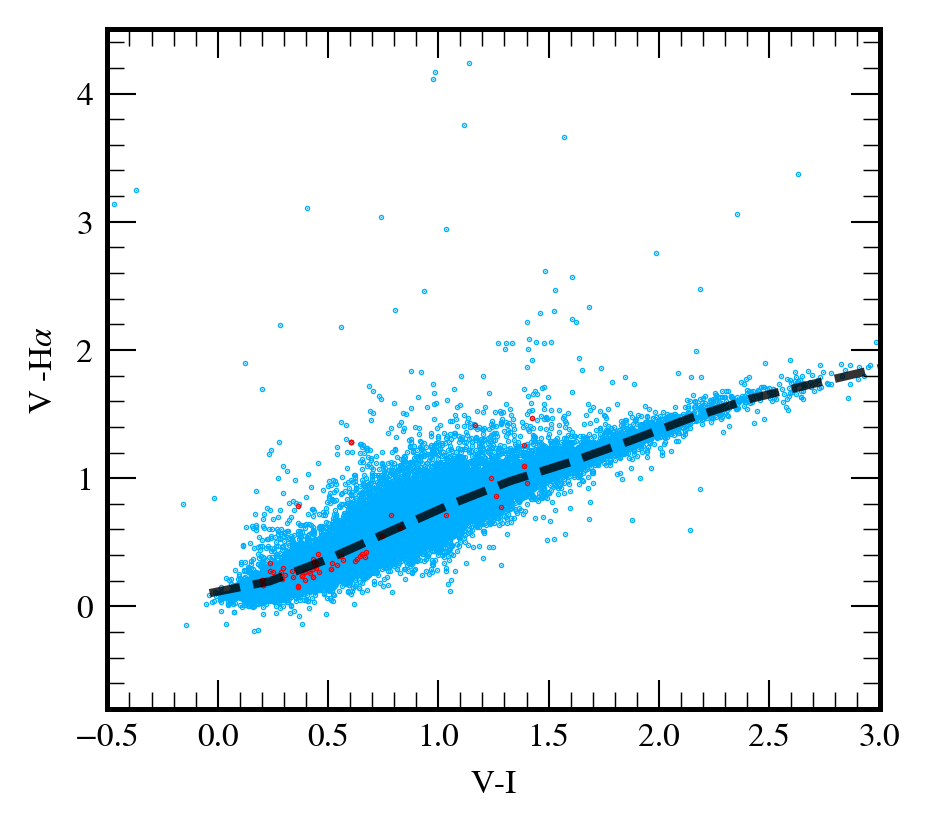

In [106]:
def referende_photometry(plot=True):
    # Now we can load Elena's catalogue and inplace the WFC3 IDs in there
    df = pd.read_pickle('../ResearchProject2/LargeField/FullCatalogue.updatedWCS.pickle')
    df2 = Jphot_df.loc[[w[0] for w in continuum_variables]].dropna()
    df['m75'] = df[['m75a','m75u']].min(axis=1)
    df['e75'] = df[['e75a','e75u']].min(axis=1)
    df = df[df.q658>0.75]
    df_clean = df[(df.q555>0.9)&(df.e555<0.1)&(df.e75<0.1)&(df.e658<0.1)].copy()
    #Jphot_df = Jphot_df[(Jphot_df.m555<90)&(Jphot_df.m658<90)&(Jphot_df.m75<90)]
    X = df_clean.m555-df_clean.m75
    Y = df_clean.m555-df_clean.m658

    X2 = df2.m555-df2.m75
    Y2 = df2.m555-df2.m658
    total_bins = 30
    bins = np.linspace(0.1,0.98*X.max(), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    running_median = np.array([np.median(Y[idx==k]) for k in range(total_bins)])
    if plot:
        plt.scatter(X, Y, s=0.1)
        plt.scatter(X2, Y2, s=0.1,color='red')
        plt.xlim(-0.5,3)
        plt.ylim(-0.8,4.5)
        plt.xlabel('V-I')
        plt.ylabel(r'V -H$\alpha$')
        plt.plot(bins-delta/2,running_median,color='black', linestyle='dashed',lw=2,alpha=.8)
        plt.show()
    return bins, delta, running_median, df_clean, X, Y
ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian, Jphot_reference, VHa_ref, VI_ref = referende_photometry()
q658_df = pd.read_pickle('./MinMax658_Q.pickle')
Jphot_reference = pd.merge(Jphot_reference, q658_df, left_index=True, right_index=True)

In [107]:
def get_Ha_var(df):
    # Define arrays
    Hamin = df.m658max
    Hamax = df.m658min
    Hamean = df.m658
    # Get average magnitude using minimum and maximum magnitude
    avgHamag = -2.5*np.log10(1/3*(10**(df.m658max/-2.5)+10**(df.m658/-2.5)+10**(df.m658min/-2.5)))
    # Take the V-I color 
    VI       = (df.m555 - df.m75)
    # V-Ha color predicted for no-excess
    # Derive Ha excess in min and max regime
    VHa_nex    = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
    interp_Ha  = df.m555 - VHa_nex
    DeltaHamax = Hamax - interp_Ha
    DeltaHamin = Hamin - interp_Ha
    # Plusha (equivalent width)
    plusHamax= abs(10**(-0.4*DeltaHamax)-1)
    plusHamin= abs(10**(-0.4*DeltaHamin)-1)
    # Get fraction of Ha
    fracHamax= plusHamax/(1+plusHamax)
    fracHamin= plusHamin/(1+plusHamin)
    addHamax = -2.5*np.log10(fracHamax)
    addHamin = -2.5*np.log10(fracHamin)

    deltamag = Hamax + addHamax - Hamin - addHamin#np.clip(Hamax + addHamax - Hamin - addHamin,0,np.inf)

    #V_flux = 10**(-0.4*df.m555) * 1.957e-19
    #Hamaxflux = 10**(-0.4*df.m658max) * 1.964e-18 - V_flux
    #Haminflux = 10**(-0.4*df.m658min) * 1.964e-18 - V_flux
    #deltamag = 2.5*np.log10((Hamaxflux/Haminflux))

    #print(deltamag[deltamag>0])
    sigma_DeltaHamax = np.sqrt(Jphot_df.e555**2+Jphot_df.e658max**2+(0.4*Jphot_df.e555)**2+(0.4*Jphot_df.e75)**2)
    sigma_DeltaHamin = np.sqrt(Jphot_df.e555**2+Jphot_df.e658min**2+(0.4*Jphot_df.e555)**2+(0.4*Jphot_df.e75)**2)

    sigma_plusHamax = np.log(10)/2.5*abs(10**(0.4*DeltaHamax)-1)*sigma_DeltaHamax
    sigma_plusHamin = np.log(10)/2.5*abs(10**(0.4*DeltaHamin)-1)*sigma_DeltaHamin

    sigma_fracHamax = 1/((1+plusHamax)**2) * sigma_plusHamax
    sigma_fracHamin = 1/((1+plusHamin)**2) * sigma_plusHamin

    sigma_addHamax  = (2.5/np.log(10))*(1/fracHamax)*sigma_fracHamax
    sigma_addHamin  = (2.5/np.log(10))*(1/fracHamin)*sigma_fracHamin

    sigma_deltamag  = np.sqrt(Jphot_df.e658max**2+Jphot_df.e658min**2 + sigma_addHamax**2+sigma_addHamin**2)

    # Equivalent Width

    # Define arrays
    Hamin = df.m658max
    Hamax = df.m658min
    # Get average magnitude using minimum and maximum magnitude
    avgHamag = -2.5*np.log10(1/3*(10**(df.m658max/-2.5)+10**(df.m658/-2.5)+10**(df.m658min/-2.5)))
    # Take the V-I color 
    VI       = (df.m555 - df.m75)
    # V-Ha color predicted for no-excess
    # Derive Ha excess in min and max regime
    VHa_nex     = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
    interp_Ha   = df.m555 - VHa_nex
    Ha_HaC_max  = - (Hamax   - interp_Ha)
    Ha_HaC_min  = - (Hamin   - interp_Ha)
    Ha_HaC_mean = - (Hamean  - interp_Ha)
    # Derive equivalent widths
    RW = 74.96
    WEQ_max  = RW * (1-10**(0.4*Ha_HaC_max))
    WEQ_min  = RW * (1-10**(0.4*Ha_HaC_min))
    WEQ_mean = RW * (1-10**(0.4*Ha_HaC_mean))

    delta_WEQ = WEQ_max - WEQ_min
    sigma_Ha_Hac_min  = np.sqrt(df.e658min**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    sigma_Ha_Hac_max  = np.sqrt(df.e658max**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    sigma_Ha_Hac_mean = np.sqrt(df.e658**2 + (0.3*np.sqrt(df.e555**2+df.e75**2))**2)
    
    eWEQ_min = RW*0.4*np.log(10)*10**(0.4*Ha_HaC_min) * sigma_Ha_Hac_min
    eWEQ_max = RW*0.4*np.log(10)*10**(0.4*Ha_HaC_max) * sigma_Ha_Hac_max
    eWEQ_mean = RW*0.4*np.log(10)*10**(0.4*Ha_HaC_mean) * sigma_Ha_Hac_mean
    sigma_dWEQ = np.sqrt(eWEQ_min**2 + eWEQ_max**2)
    
    return avgHamag, deltamag, sigma_deltamag, delta_WEQ, sigma_dWEQ, WEQ_max, WEQ_min, WEQ_mean, eWEQ_max, eWEQ_min, eWEQ_mean, Ha_HaC_max, Ha_HaC_min, Ha_HaC_mean, sigma_Ha_Hac_max, sigma_Ha_Hac_min, sigma_Ha_Hac_mean

In [108]:
(avgHamag, deltamag, sigma_deltamag, delta_eqwidth, 
           e_eqwidth, WEQ_max, WEQ_min, WEQ_mean, 
           eWEQ_max, eWEQ_min, eWEQ_mean, Ha_HaC_max, 
           Ha_HaC_min, Ha_HaC_mean, sigma_Ha_HaC_max, 
           sigma_Ha_HaC_min, sigma_Ha_HaC_mean) = get_Ha_var(Jphot_reference)
Jphot_reference['avgHamag'] = avgHamag
Jphot_reference['deltamag'] = deltamag
Jphot_reference['edeltamag'] = sigma_deltamag
Jphot_reference['delta_eqwidth'] = delta_eqwidth
Jphot_reference['edelta_eqwidth'] = e_eqwidth
Jphot_reference['eqwidth_max'] = WEQ_max
Jphot_reference['eqwidth_min'] = WEQ_min
Jphot_reference['e_eqwidth_max'] = eWEQ_max
Jphot_reference['e_eqwidth_min'] = eWEQ_min
Jphot_reference['eqwidth'] = WEQ_mean
Jphot_reference['e_eqwidth'] = eWEQ_mean
Jphot_reference['Ha_HaC_min'] = Ha_HaC_min
Jphot_reference['Ha_HaC_max'] = Ha_HaC_max
Jphot_reference['Ha_HaC_mean'] = Ha_HaC_mean
Jphot_reference['e_Ha_HaC_min'] = sigma_Ha_HaC_min
Jphot_reference['e_Ha_HaC_max'] = sigma_Ha_HaC_max
Jphot_reference['e_Ha_HaC_mean'] = sigma_Ha_HaC_mean

goodmask = Jphot_reference.index[(Jphot_reference.q658>0.75)&(Jphot_reference.e555<0.1)&(Jphot_reference.e75<0.1)&(np.sqrt((Jphot_reference.e658min)**2+(Jphot_reference.e658max)**2)<0.25)]
Jphot_reference = Jphot_reference.loc[goodmask]

(avgHamag, deltamag, sigma_deltamag, delta_eqwidth, 
           e_eqwidth, WEQ_max, WEQ_min, WEQ_mean, 
           eWEQ_max, eWEQ_min, eWEQ_mean, Ha_HaC_max, 
           Ha_HaC_min, Ha_HaC_mean, sigma_Ha_HaC_max, 
           sigma_Ha_HaC_min, sigma_Ha_HaC_mean) = get_Ha_var(Jphot_df)
Jphot_df['avgHamag'] = avgHamag
Jphot_df['deltamag'] = deltamag
Jphot_df['edeltamag'] = sigma_deltamag
Jphot_df['delta_eqwidth'] = delta_eqwidth
Jphot_df['edelta_eqwidth'] = e_eqwidth
Jphot_df['eqwidth_max'] = WEQ_max
Jphot_df['eqwidth_min'] = WEQ_min
Jphot_df['e_eqwidth_max'] = eWEQ_max
Jphot_df['e_eqwidth_min'] = eWEQ_min
Jphot_df['eqwidth'] = WEQ_mean
Jphot_df['e_eqwidth'] = eWEQ_mean
Jphot_df['Ha_HaC_min'] = Ha_HaC_min
Jphot_df['Ha_HaC_max'] = Ha_HaC_max
Jphot_df['Ha_HaC_mean'] = Ha_HaC_mean
Jphot_df['e_Ha_HaC_min'] = sigma_Ha_HaC_min
Jphot_df['e_Ha_HaC_max'] = sigma_Ha_HaC_max
Jphot_df['e_Ha_HaC_mean'] = sigma_Ha_HaC_mean
goodmask = Jphot_df.index[(Jphot_df.q658>0.75)&(Jphot_df.e555<0.1)&(Jphot_df.e75<0.1)&(Jphot_df.e658min<0.1)&(Jphot_df.e658max<0.1)&(np.sqrt((Jphot_df.e658min)**2+(Jphot_df.e658max)**2)<0.2)]
Jphot_df = Jphot_df.loc[goodmask]

/home/luuk/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


2120
Total number of stars:  2084
Total number of PMS stars:  139
Five sigma stars:  44
Five sigma PMS stars:  5


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https

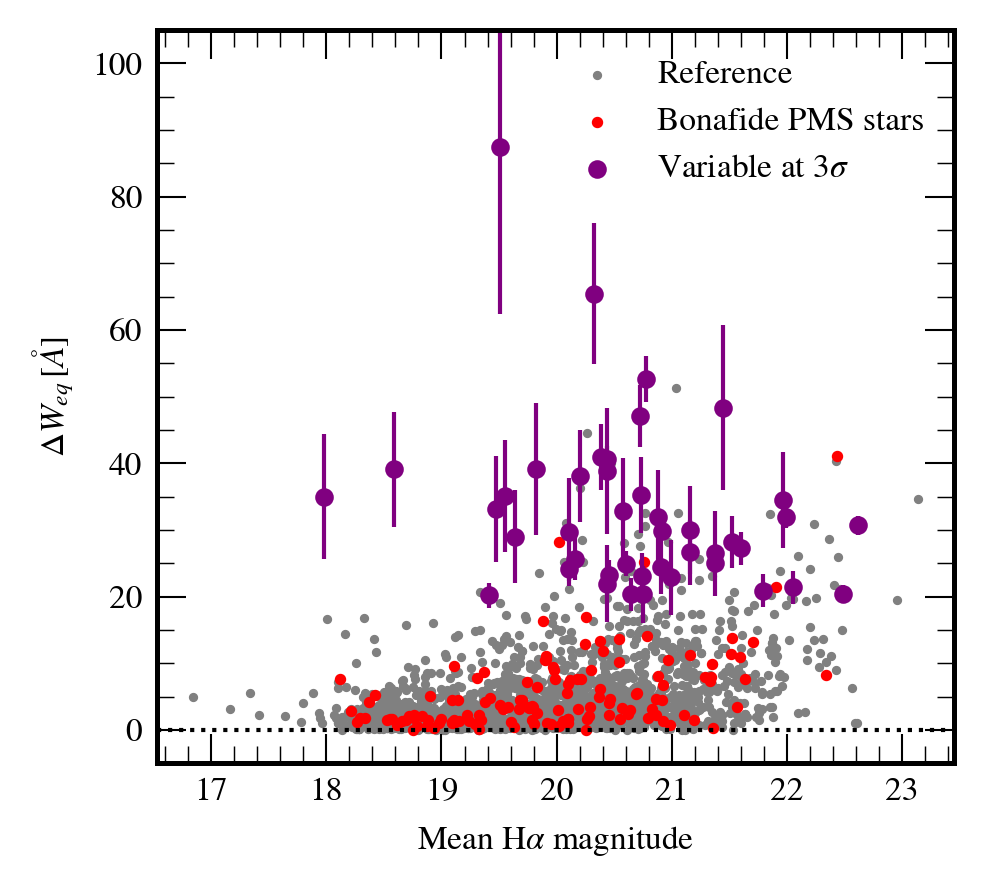

In [110]:
def plot_Ha_var(df, q_thresh, how='line'):
    try:df = df[(df.q658max>q_thresh)&(df.q658min>q_thresh)&(df.q555>q_thresh)]
    except:pass
    print(len(df))

    if how=='eqwidth':
        fig, ax = plt.subplots()
        df['delta_eqwidth'] = df['delta_eqwidth'].abs()#[df.eqwidth>0]
        #df = df.dropna()
        df = df[df.delta_eqwidth!=0]
        #df = df.dropna()
        no_pms = df.drop([w for w in df.loc[pms_ids].dropna().index]).index
        print("Total number of stars: ",len(df))
        no_pms_x = df.loc[no_pms].avgHamag
        no_pms_y = df.loc[no_pms].delta_eqwidth
        #no_pms_e = np.sqrt((df.loc[no_pms].e658min**2 + df.loc[no_pms].e658max**2))
        ax.scatter(no_pms_x,no_pms_y, s=1.5, color='grey', label='Reference')
        #plt.errorbar(no_pms_x,no_pms_y,no_pms_e, color='grey', ls='none')

        pms_x = df.loc[pms_ids].avgHamag
        pms_y = df.loc[pms_ids].delta_eqwidth
        ax.scatter(pms_x,pms_y, s=3, label='Bonafide PMS stars', color='red')
        print("Total number of PMS stars: ",len(pms_x.dropna()))
        
        
        all_x = df.avgHamag
        all_y = df.delta_eqwidth
        all_e = df['edelta_eqwidth']

        total_bins = 10
        bins = np.linspace(18,23, total_bins)
        delta = bins[1]-bins[0]
        idx  = np.digitize(all_x,bins)
        running_median = np.array([np.nanmedian(all_y[idx==k]) for k in range(total_bins)])
        running_std    = np.array([np.std(all_y[idx==k]) for k in range(total_bins)])

        all_y_interp = interp_func(all_x,bins, delta, running_median)
        five_sigma = ((all_y-all_y_interp) / all_e >=3) * (all_y>20) * df.eqwidth_min<0
        print("Five sigma stars: ",five_sigma.sum())
        print("Five sigma PMS stars: ",np.sum(five_sigma.loc[pms_ids].dropna()))

        ax.scatter(all_x[five_sigma],all_y[five_sigma], s=12, label=r'Variable at 3$\sigma$', color='purple')
        ax.errorbar(all_x[five_sigma],all_y[five_sigma], all_e[five_sigma], ls='none', color='purple', lw=1)
        
        
        ax.set_xlabel(r'Mean H$\alpha$ magnitude')#, size=15)
        ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$')#, size=15)
        
        plt.legend()#loc='upper left')
        plt.tight_layout()
        ax.axhline(0, color='black', ls='dotted', lw='1')
        #plt.semilogy()
        ax.set_ylim(-5,105)
        fig.savefig('ACS_Ha_var_centralregion.pdf',dpi=500,bbox_inches='tight')
        plt.show()
        
        return df[five_sigma]
#Jphot_variable = plot_Ha_var(Jphot_df,0.7, 'noline')
#Jphot_variable = plot_Ha_var(Jphot_df,0.75, 'line')

#ACS_Luuk_variable = plot_Ha_var(ACS_df,0.8, 'eqwidth')
Jphot_variable = plot_Ha_var(Jphot_df,0.8, 'eqwidth')
Ha_var_IDs = Jphot_variable.index

In [ ]:
continuum_var_ids = np.unique([w[0] for w in continuum_variables if w[1]=='F555W'])

In [ ]:
len(np.intersect1d(continuum_var_ids,Ha_var_IDs))/len(Ha_var_IDs)*100

In [ ]:
MagMadeMAD.loc[Jphot_variable.index].MAD.median()

In [ ]:
a=wfc3_broadband_df.loc[Jphot_variable.index]
b=a.groupby(['ID','Filter'])['mag'].max() - a.groupby(['ID','Filter'])['mag'].min()
c=a.groupby(['ID','Filter'])['emag'].median()*np.sqrt(2)
d=pd.merge(b,c, left_index=True,right_index=True)
d['sigma'] = d.mag/d.emag
e=Jphot_variable.delta_eqwidth
e.index.name='ID'
f=pd.merge(d,e,left_index=True,right_index=True)
f=f[f.sigma>5]
f=f[f.index.get_level_values(1)=='F555W']
f.plot.scatter(y='mag', x='delta_eqwidth')
f

In [ ]:
MagMadeMAD.loc[fivesigma_continuum]#.loc[Ha_var_IDs]

/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luuk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

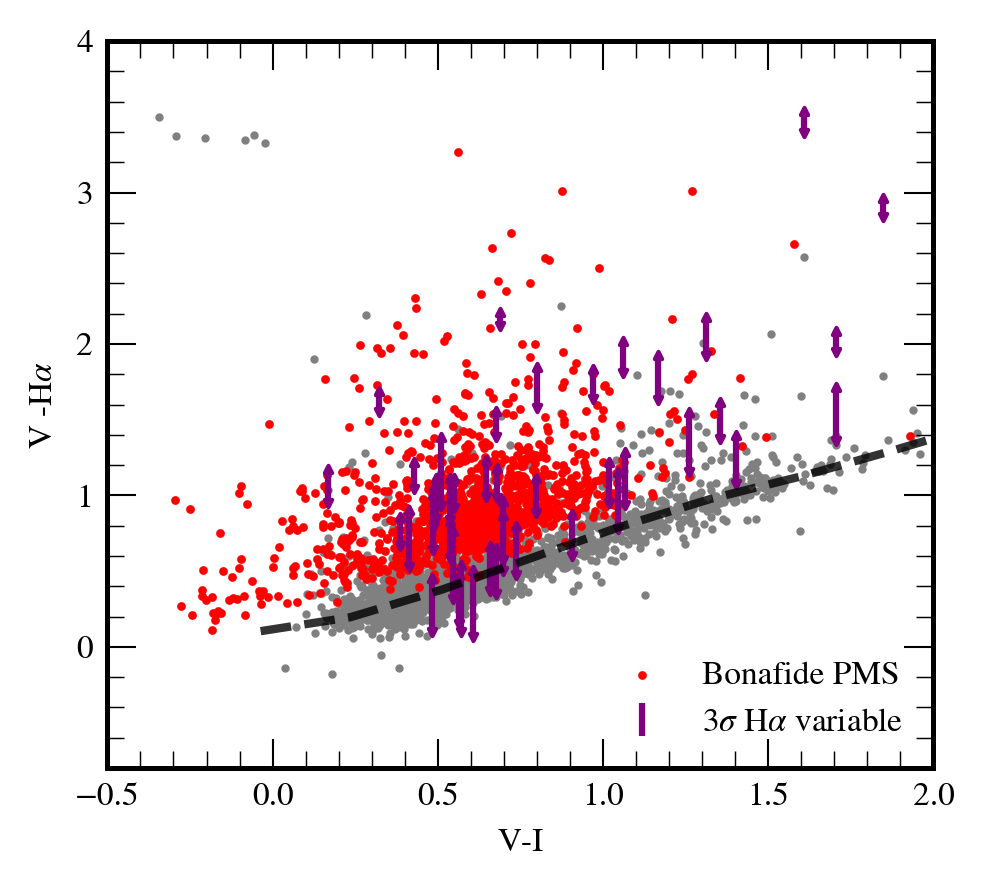

In [117]:
def plot_variable_HR(variable_df):
    plt.figure()#figsize=(8,5))
    ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian, Jphot_reference, VHa_ref, VI_ref = referende_photometry(plot=False)
    VHa_ref = (Jphot_df.m555 - Jphot_df.m658)
    VI_ref  = (Jphot_df.m555 - Jphot_df.m75)
    
    VHa_ref_pms = (ACS_pms_df.V - ACS_pms_df.Ha).loc[pms_ids].dropna()
    VI_ref_pms  = (ACS_pms_df.V - ACS_pms_df.I).loc[pms_ids].dropna()
    PMS_mask = (VHa_ref_pms > interp_func(VI_ref_pms, ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian))
    VHa_ref_pms = VHa_ref_pms[PMS_mask]
    VI_ref_pms  = VI_ref_pms[PMS_mask]
    
    
    plt.scatter(VI_ref, VHa_ref, s=1, color='grey')
    #plt.scatter(VI_ref_pms, VHa_ref_pms, s=0.8, color='red', label='Bonafide PMS')
    plt.scatter(VI_ref_pms,VHa_ref_pms, s=1.2, color='red', label='Bonafide PMS')
    #plt.scatter(VI_ref.loc[fivesigma_continuum],VHa_ref.loc[fivesigma_continuum], s=20,marker='v', color='black', label='Continuum variables')
    
    
    
    plt.xlim(-0.5,2.)
    plt.ylim(-0.8,4.)
    
    plt.xlabel('V-I')#, size=15)
    plt.ylabel(r'V -H$\alpha$')#, size=15)
    plt.plot(ref_VHa_bins-ref_VHa_delta/2,ref_VHa_runmedian,color='black', linestyle='dashed',lw=2,alpha=.8)
    VI_variable = variable_df['m555'] - variable_df['m75']
    VHa_max = variable_df['m555']-variable_df['m658max']
    VHa_min = variable_df['m555']-variable_df['m658min']
    VHa_mean = 1/2*(VHa_max+VHa_min)
    VHa_delta = (VHa_max - VHa_min)/2
    plt.errorbar(VI_variable, VHa_mean, VHa_delta, ls='none', color='purple', label=r'$3\sigma$ H$\alpha$ variable',lw=1.5)
    plt.scatter(VI_variable, VHa_mean+VHa_delta,s=3, color='purple',marker="^")
    plt.scatter(VI_variable, VHa_mean-VHa_delta,s=3, color='purple',marker="v")
    #plt.scatter(Jphot_variable['m555'] - Jphot_variable['m75'],Jphot_variable['m555']-Jphot_variable['m658max'],s=3)
    #plt.scatter(Jphot_variable['m555'] - Jphot_variable['m75'],Jphot_variable['m555']-Jphot_variable['m658min'],s=3)
    
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('HR_with_variability.pdf', dpi=500, bbox_inches='tight')
    plt.show()
plot_variable_HR(Jphot_variable)

In [213]:
def deltaWEQ_vsExcess(df,q_thresh=0.8):
    try:df = df[(df.q658max>q_thresh)&(df.q658min>q_thresh)&(df.q555>q_thresh)]
    except:pass
    fig, ax = plt.subplots()
    VHamax = df.m555 - df.m658max
    VHamin = df.m555 - df.m658min
    VI = df.m555 - df.m75
    VHa_interp = interp_func(VI,ref_VHa_bins,ref_VHa_delta,ref_VHa_runmedian)
    Ha_excess_max = VHamax - VHa_interp
    Ha_excess_min = VHamin - VHa_interp
    delta_eqwidth = df.delta_eqwidth
    delta_Ha_excess = Ha_excess_max - Ha_excess_min
    mean_Ha_excess = 1/2*(Ha_excess_min+Ha_excess_max)
    
    fivesigma_excess = Ha_excess_max / df.e658max > 5
    
    excess = df[(df.eqwidth_min<-20)&(df.eqwidth_max<-20)&(df.Ha_HaC_max / df.e_Ha_HaC_max > 5)&(df.Ha_HaC_min / df.e_Ha_HaC_min > 5)].index
    print(len(excess))
    #delta_eqwidth = np.log10(df.delta_eqwidth)
    ax.scatter(Ha_excess_max,delta_eqwidth,s=2, c='grey')
    ax.scatter(Ha_excess_max.loc[excess],delta_eqwidth.loc[excess],s=3, c='red', label=r'$5\sigma$ excess')
    ax.set_xlim(-1,5)
    #plt.scatter(mean_Ha_excess.loc[fivesigma_excess],delta_eqwidth.loc[fivesigma_excess],s=11,marker="v", c='red', label=r'$5\sigma$ excess')
    #ax.semilogy()
    RW = 74.96
    #secax = ax.secondary_xaxis('top', functions=((lambda x: RW*(1-10**(-0.4*x))),(lambda x: -2.5*np.log10(1-x/RW))))
    

    def tick_function(X):
        Weq = RW * (1-10**(0.4*X))
        return -Weq
    
    def inv_tick_function(Y):
        return 2.5*np.log(-Y/RW-1)
    ax2 = ax.twiny()
    #new_tick_locations = np.arange(-1,5,1)
    ax2.set_xlim(tick_function(-1),tick_function(5))
    #ax2.set_xticks(new_tick_locations)
    ax2.set_xscale('log')
    #ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r"$\mathrm{max(W_{EQ})}\, [\AA]$")
    EW_ticks = np.array([0,2000,4000,6000])
    X_ticks = inv_tick_function(EW_ticks)
    #ax2.set_xticks([])
    #ax2.set_xticklabels([])
    #ax2.scatter(tick_function(Ha_excess_max),delta_eqwidth,s=2, c='grey')
    #WEQ = RW * (1-10**(-0.4x)
    #WEQ/RW -1
    #secax.set_xlabel(r'Equivalent Width [$\AA$]', size=15)
    ax.set_ylim(0.6,1.1e3)
    #ax.set_xticks(size=15)
    #ax.set_yticks(np.arange(0,3.1,1))
    ax.semilogy()
    #plt.yticks(size=15)
    ax.set_xlabel(r"$\mathrm{H\alpha - H\alpha^{C}}$")
    ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$')
    ax.set_yticks([1,10,100,1000])
    ax.set_yticklabels(['1','10','100','1000'])
    

    #plt.legend(loc='best', fontsize=14)
    plt.tight_layout()
    plt.savefig('delta_Weq_vs_Haexcess.pdf', dpi=600, bbox_inches='tight')
deltaWEQ_vsExcess(Jphot_df)

294


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3622563170> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [212]:
-74*(1-10**(0.4*4))

2871.9930620958803

In [ ]:
def EW_VI_plot(Jphot_df):
    #Jphot_df = Jphot_df[(Jphot_df.q658max>0.8)&(Jphot_df.q658>0.75)]
    plt.figure()
    x = Jphot_df.m555 - Jphot_df.m75
    y_mean = Jphot_df.eqwidth
    plt.scatter(x, y_mean, s=0.5, color='grey')
    plt.axhline(20, color='black', ls='dotted', lw='1')

    x_central = Jphot_df.m555 - Jphot_df.m75
    y_central = (-Jphot_df.eqwidth)
    e_central = Jphot_df.e_eqwidth
    y_central_max = -Jphot_df.eqwidth_max
    e_central_max = Jphot_df.e_eqwidth_max
    eHa_HaC_mean = 0.738*Jphot_df.e_Ha_HaC_mean


    PMS_cand  = (y_central>=20) * (x_central>0.2) * (Jphot_df.Ha_HaC_mean / eHa_HaC_mean >= 5)
    PMS_cand_max  = (y_central_max>=20) * (x_central>0.2) * (Jphot_df.Ha_HaC_max / Jphot_df.e_Ha_HaC_max >= 5)
    PMS_cand_AeBe  = (y_central>=20) * (x_central<=0.2) * (Jphot_df.Ha_HaC_mean / eHa_HaC_mean >= 5)
    PMS_cand_max_AeBe  = (y_central_max>=20) * (x_central<=0.2) * (Jphot_df.Ha_HaC_max / Jphot_df.e_Ha_HaC_max >= 5)

    
    new_PMS = PMS_cand_max * np.logical_not(PMS_cand)
    a = new_PMS
    a.loc[[w for w in pms_ids if w in new_PMS.index[new_PMS]]] = False
    print("PMS for single magnitude: ", np.sum(PMS_cand))
    print("Newly found: ", np.sum(new_PMS))

    plt.scatter(x_central[new_PMS], y_central_max[new_PMS], s=3, color='red', label='Ha emitter at max brightness')
    plt.scatter(x_central[PMS_cand], y_central[PMS_cand], s=3, color='black', label='Ha emitter at mean brightness')
 
    #AeBe_candidates = (x_central<0.2)*y_central>20
    #plt.scatter(x_central[AeBe_candidates], y_central[AeBe_candidates], s=15, color='purple', label='Ae/Be candidates')
    plt.scatter(x_central[PMS_cand_max_AeBe], y_central_max[PMS_cand_max_AeBe], s=3,marker='s', color='red')
    plt.scatter(x_central[PMS_cand_AeBe], y_central[PMS_cand_AeBe], s=3, color='black',marker='s')
    
    plt.ylim(-50,400)
    plt.xlabel("V-I")
    plt.ylabel(r'$W_{eq}\, [\AA]$')
    plt.tight_layout()
    lgnd = plt.legend(loc='best', numpoints=1)
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    #lgnd.legendHandles[2]._sizes = [20]
    plt.xlim(-0.3,2.8)

    plt.savefig('EqWidth_VI.pdf', dpi=500, bbox_inches='tight')
EW_VI_plot(Jphot_df)

<h3>Luminosity difference</h3>

In [ ]:
def get_line_luminosities(Ha_HaC, how='log'):
    photflam = 1.966e-18 # erg / cm2 / A / s
    lambda_c = 6583.9 # A
    RW = 74.96
    dist = 51.4 # kpc
    dist = dist  * 3.086e21 #cm
    luminos = 10**(-Ha_HaC/2.5) * photflam * RW * 4*np.pi*dist**2
    solarluminos = luminos / 3.83e33
    if how=='log':
        return np.log10(luminos)
    elif how=='solar':
        return solarluminos
    else:
        return luminos

In [ ]:
diff_solar_luminos = Jphot_df.Ha_HaC_max.apply(lambda x: get_line_luminosities(x, 'solar')) - Jphot_df.Ha_HaC_min.apply(lambda x: get_line_luminosities(x, 'solar'))
diff_solar_luminos = diff_solar_luminos[Jphot_df.delta_eqwidth>20]
diff_solar_luminos = diff_solar_luminos/(3e8)**2 * 2e30
diff_solar_luminos#.hist(bins=np.arange(0.001,0.012,0.001), histtype='step', lw=2)
#plt.xlabel(r'Difference in L(H$\alpha$) [$L_{\odot}$]')


<h3>Plot locations</h3>

In [ ]:
import scipy as sp
import scipy.ndimage

def get_density_contours(plot=False):
    WFC3_coverage = fits.open('./WFC3_Broadband/flt_files/F814W/F814_WFC3_drz.fits')[1].data
    sigma_y = 110.0
    sigma_x = 110.0

    # Create input array
    stars = np.zeros(WFC3_coverage.shape) 
    for i,row in pms.iterrows():
        stars[int(row.Y),int(row.X)] += 1

    if plot:
        # Plot input array
        plt.imshow(stars, cmap='Blues', interpolation='nearest')
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        #plt.savefig("array.png")
        plt.show()
    
    # Apply gaussian filter
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.filters.gaussian_filter(stars, sigma, mode='constant')
    # From stars per pixel to stars per square parsec
    pms_density = y / (0.01**2)
    if plot:
        plt.imshow(pms_density, cmap='Blues', interpolation='nearest')
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.title("$\sigma_x = " + str(sigma_x) + "\quad \sigma_y = " + str(sigma_y) + "$")
        plt.colorbar()
        plt.show()
    return pms_density
    
    #return pms
pms_density = get_density_contours()
plt.imshow(pms_density)
plt.colorbar()

In [1]:
import aplpy
def plot_locations(df):
    e_delta_eqwidth = np.sqrt(Jphot_df.e_eqwidth_max**2 + Jphot_df.e_eqwidth_min**2)
    df = df[(df.delta_eqwidth>=20)]
    delta_eqwidth = df.delta_eqwidth
    binedges = [25,33,1e9]
    low = df[(delta_eqwidth<binedges[0])&(e_delta_eqwidth<26/3)].index#.sample(30).index
    mid = df[(delta_eqwidth<binedges[1])&(delta_eqwidth>=binedges[0])&(e_delta_eqwidth<35/3)].index
    high = df[(delta_eqwidth>=binedges[1])&(e_delta_eqwidth<35/3)].index
    print(len(low), len(mid), len(high))
    x_low, y_low = wfc3_catalogue.loc[low]['x'].values, wfc3_catalogue.loc[low]['y'].values
    x_mid, y_mid = wfc3_catalogue.loc[mid]['x'].values, wfc3_catalogue.loc[mid]['y'].values
    x_high, y_high = wfc3_catalogue.loc[high]['x'].values, wfc3_catalogue.loc[high]['y'].values
    
    WFC3_coverage = fits.open('./WFC3_Broadband/flt_files/F814W/F814_WFC3_drz.fits')[1].data
    WFC3_coverage = np.where(np.isfinite(WFC3_coverage), 1, np.nan)
    ACS_Ha_data = fits.open('./ACS_Ha/flc_files/F658N_ACS_WFC3_drz.fits')[1].data
    ACS_Ha_header = fits.open('./ACS_Ha/flc_files/F658N_ACS_WFC3_drz.fits')[1].header
    ACS_Ha_data = ACS_Ha_data * WFC3_coverage
    Vband_data = fits.open('../ResearchProject2/HST_Guido/30dorf555drz.fits')[0].data
    Vhdu = fits.ImageHDU(data=Vband_data, header=ACS_Ha_header)
    pms_hdu = fits.ImageHDU(data=pms_density, header=ACS_Ha_header)
    
    canvas = plt.figure()#figsize=(10,10))
    plt.rcParams['axes.linewidth'] = 2
    
    fig = aplpy.FITSFigure(Vhdu, figure=canvas)
    
    RA_lows, DEC_lows = fig.pixel2world(x_low, y_low)
    RA_mids, DEC_mids = fig.pixel2world(x_mid, y_mid)
    RA_highs, DEC_highs = fig.pixel2world(x_high, y_high)
    
    fig.show_colorscale(pmin=35, pmax=99.6, stretch='log')
    fig.set_theme('publication')
    #fig.show_colorbar()
    #fig.colorbar.set_font(size=16)
    #fig.colorbar.set_axis_label_text('Number of measurements')
    #fig.colorbar.set_axis_label_font(size=17)
    #fig.tick_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    #fig.axis_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    fig.tick_labels.set_xformat('hhmmss')
    fig.tick_labels.set_yformat('ddmmss')
    fig.show_contour(pms_hdu, levels=np.logspace(-0.4,1.,10), colors='black', smooth=True, linewidths=0.7)
    plt.tight_layout()


    fig.show_markers(RA_lows, DEC_lows, layer='markers_low', edgecolor='blue', facecolor='blue', marker='o', s=6, label=r'$20\mathrm{\AA} < \mathrm{\Delta W_{eq}} < 25\mathrm{\AA}$')
    fig.show_markers(RA_mids, DEC_mids, layer='markers_mid', edgecolor='red', facecolor='red', marker="^", s=6, label=r'$25\mathrm{\AA} < \mathrm{\Delta W_{eq}} < 33 \mathrm{\AA}$')
    fig.show_markers(RA_highs, DEC_highs, layer='markers_high', edgecolor='orange', facecolor='orange', marker="s", s=6, label=r'$\mathrm{\Delta W_{eq}} > 33 \mathrm{\AA}$')
    #fig.recenter(np.median(RA_mids)-0.012, np.median(DEC_mids)+0.013, radius=0.034)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.48, +1.1),
    #fancybox=True, shadow=True, ncol=3,fontsize=5.7)
    legend = plt.legend(frameon = 1, fontsize=6)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_linewidth(0)
    plt.savefig('Vmap_with_lowmidhigh_deltaWEQ.pdf', dpi=350, bbox_inches='tight')
plot_locations(Jphot_df)

NameError: name 'Jphot_df' is not defined

Length our data 7244
Length marchi 2011 data 14421


/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/luuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use

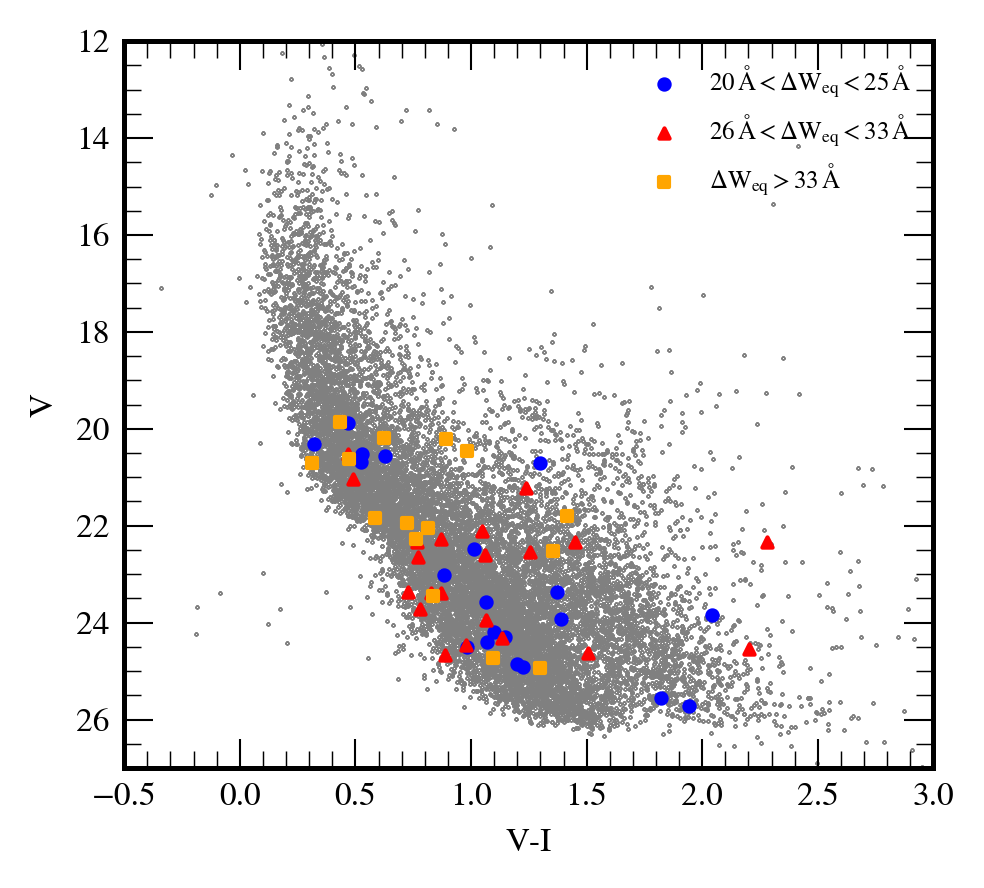

In [176]:
def plot_HR_with_vars():
    df = pd.DataFrame({'MAG':wfc3_broadband_df.groupby(['ID','Filter'])['mag'].median(),
                       'eMAG':wfc3_broadband_df.groupby(['ID','Filter'])['emag'].mean()})
    
    df = df[df.eMAG<0.07]
    df = df[(df.index.get_level_values(1)=='F555W')+(df.index.get_level_values(1)=='F814W')]
    df = df.unstack().dropna()
    print("Length our data",len(df))
    all_stars_lowerr = all_stars_read[(all_stars_read.ei_2<0.07)&(all_stars_read.ev_2<0.07)]
    print("Length marchi 2011 data",len(all_stars_lowerr))

    
    e_delta_eqwidth = np.sqrt(Jphot_df.e_eqwidth_max**2 + Jphot_df.e_eqwidth_min**2)
    dfa=Jphot_df
    dfa = dfa[(dfa.delta_eqwidth>=20)]
    delta_eqwidth = dfa.delta_eqwidth
    binedges = [25,33,1e9]
    low = dfa[(delta_eqwidth<binedges[0])&(e_delta_eqwidth<26/3)].index#.sample(30).index
    mid = dfa[(delta_eqwidth<binedges[1])&(delta_eqwidth>=binedges[0])&(e_delta_eqwidth<35/3)].index
    high = dfa[(delta_eqwidth>=binedges[1])&(e_delta_eqwidth<35/3)].index

    
    
    this_work = df.index
    VI = all_stars_lowerr.v_1 - all_stars_lowerr.i_1
    V  = all_stars_lowerr.v_1
    
    plt.figure()#figsize=(8,5))
    plt.scatter(all_stars_lowerr.v_1-all_stars_lowerr.i_1, all_stars_lowerr.v_1, facecolor='grey', marker='*',s=0.002)#, label='de Marchi et al. (2017)')
    #plt.scatter(VI.loc[this_work], V.loc[this_work],s=3, color='black',alpha=0.3)
    #plt.scatter(VI.loc[high_var], V.loc[high_var],s=35, color='red')
    #plt.scatter(VI.loc[Ha_var_IDs], V.loc[Ha_var_IDs],s=14, color='red', label=r'3$\sigma$ variability')
    
    
    plt.scatter(VI.loc[low], V.loc[low], edgecolor='blue', facecolor='blue', marker='o', s=6, label=r'$20\, \mathrm{\AA} < \mathrm{\Delta W_{eq}} < 25\, \mathrm{\AA}$')
    plt.scatter(VI.loc[mid], V.loc[mid], edgecolor='red', facecolor='red', marker="^", s=6, label=r'$26\, \mathrm{\AA} < \mathrm{\Delta W_{eq}} < 33\, \mathrm{\AA}$')
    plt.scatter(VI.loc[high], V.loc[high], edgecolor='orange', facecolor='orange', marker="s", s=6, label=r'$\mathrm{\Delta W_{eq}} > 33\, \mathrm{\AA}$')
    
    
    
    #plt.scatter(VI.loc[this_work].iloc[0], V.loc[this_work].iloc[0],s=0.01, color='black', label='This work')
    
    plt.xlabel('V-I')
    plt.ylabel(r'V')
    plt.tight_layout()
    plt.xlim(-0.5,3)
    plt.ylim(27,12)
    lgnd = plt.legend(numpoints=1,fontsize=6)
    #change the marker size manually for both lines
    #lgnd.legendHandles[0]._sizes = [20]
    #lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[1]._colors = ['black']
    lgnd.legendHandles[1]._alphas = [1]
    #lgnd.legendHandles[2]._sizes = [10]
    
    
    plt.tight_layout()
    plt.savefig('VI_V_CMD.pdf', dpi=500,bbox_inches='tight')
    return 
plot_HR_with_vars()

In [ ]:
def compare_central3_Ha():
    WFC3_central_Ha = pd.read_pickle('./WFC3_Ha_central3/WFC3_Ha_central3.pickle')
    WFC3_central_Ha.columns = ['mag3','emag3']
    WFC3_all_Ha     = pd.read_pickle('./WFC3_Ha_all/WFC3_Ha_notcentral3.pickle')
    WFC3_all_Ha.columns = ['mag_all','emag_all']
    
    WFC3_Ha_compare = pd.merge(WFC3_all_Ha, WFC3_central_Ha, left_index=True, right_index=True)
    
    plt.figure(figsize=(8,5))
    plt.scatter(WFC3_Ha_compare.mag_all, WFC3_Ha_compare.mag3, s=0.2,color='black', label='Stars in both datasets')
    combined_error = WFC3_Ha_compare.emag3
    abs_offset     = np.abs(WFC3_Ha_compare.mag_all-WFC3_Ha_compare.mag3)
    sigma_offset   = abs_offset / combined_error
    significant    = sigma_offset>5
    print(significant.sum())
    plt.scatter(WFC3_Ha_compare.mag_all[significant], WFC3_Ha_compare.mag3[significant], s=12, color='red', label='5 sigma difference')
    
    plt.plot([12,23],[12,23], color='red')
    plt.ylabel('Central three magnitudes')
    plt.ylim(20,16)
    plt.xlim(16,20)
    plt.xlabel('Average magnitude epochs', size=13)
    plt.ylabel('Magnitude in three consecutive epochs', size=13)
    lgd = plt.legend(loc='best', fontsize=14,numpoints=1)
    lgd.legendHandles[0]._sizes = [20]
    lgd.legendHandles[1]._sizes = [20]
    
    plt.show()
    
    return
    
compare_central3_Ha()

In [ ]:
def compare_Giacomo_central3():
    plt.figure(figsize=(8,5))
    WFC3_central_Ha = pd.read_pickle('./WFC3_Ha_central3/WFC3_Ha_central3.pickle')
    #WFC3_central_Ha.mag -= 0.27
    WFC3_central_Ha = WFC3_central_Ha[WFC3_central_Ha.emag<0.1]
    Giacomo_Ha = wfc3_catalogue[['ha_1', 'eha_2']]
    Giacomo_Ha = Giacomo_Ha[Giacomo_Ha.ha_1>0]
    Giacomo_Ha = Giacomo_Ha[Giacomo_Ha.eha_2<0.1]
    both_Ha = pd.merge(WFC3_central_Ha, Giacomo_Ha, left_index=True, right_index=True)
    plt.scatter(both_Ha.mag, both_Ha.ha_1, s=1)
    
    combined_error = np.sqrt(both_Ha.eha_2**2 + both_Ha.emag**2)
    abs_offset     = np.abs(both_Ha.mag-both_Ha.ha_1)
    sigma_offset   = abs_offset / combined_error
    significant    = sigma_offset>5
    plt.scatter(both_Ha.mag[significant], both_Ha.ha_1[significant], s=3, color='red')
    
    plt.plot([12,23],[12,23], color='red')
    plt.ylabel('Central three magnitudes')
    plt.ylim(26,10)
    plt.show()
    return (both_Ha.mag-both_Ha.ha_1).hist(bins=np.arange(-1,1,0.05)),(both_Ha.mag-both_Ha.ha_1).mean()
compare_Giacomo_central3()

In [ ]:
def compare_Ha_U(df):
    a = wfc3_broadband_df[wfc3_broadband_df.index.get_level_values(1)=='F336W']
    minmag = a.groupby('ID')['mag'].idxmin()
    maxmag = a.groupby('ID')['mag'].idxmax()
    #a = a.drop(minmag)
    
    iminmag = a.groupby('ID')['mag'].idxmin()
    imaxmag = a.groupby('ID')['mag'].idxmax()
    minmag = a.groupby('ID')['mag'].min()
    maxmag = a.groupby('ID')['mag'].max()
    eminmag = a.loc[iminmag]['emag']
    emaxmag = a.loc[imaxmag]['emag']
    eminmax = np.sqrt(emaxmag.droplevel([1,2])**2+eminmag.droplevel([1,2])**2)
    
    minmax_U = maxmag - minmag
    minmax_U = minmax_U[minmax_U/eminmax>3]

    e_delta_eqwidth = np.sqrt(Jphot_df.e_eqwidth_max**2 + Jphot_df.e_eqwidth_min**2)
    df = df[(df.delta_eqwidth>=20)]
    delta_eqwidth = df.delta_eqwidth
    
    delta_U = minmax_U.loc[delta_eqwidth.index].dropna()
    plt.errorbar(delta_eqwidth.loc[delta_U.index], delta_U, eminmax.loc[delta_U.index], ls='none', lw=1)
    plt.xlim(0,50)
    plt.show()
    return delta_U.index
U_candidates = compare_Ha_U(Jphot_df)

In [ ]:
def compare_Ha_U_2():
    # 1 get all variable U stars
    a = wfc3_broadband_df[wfc3_broadband_df.index.get_level_values(1)=='F336W']
    iminmag = a.groupby('ID')['mag'].idxmin()
    imaxmag = a.groupby('ID')['mag'].idxmax()
    minmag = a.groupby('ID')['mag'].min()
    maxmag = a.groupby('ID')['mag'].max()
    eminmag = a.loc[iminmag]['emag']
    emaxmag = a.loc[imaxmag]['emag']
    eminmax = np.sqrt(emaxmag.droplevel([1,2])**2+eminmag.droplevel([1,2])**2)
    
    minmax_U = maxmag - minmag
    minmax_U = minmax_U[minmax_U/eminmax>5]
    minmax_U = minmax_U[minmax_U>0.08]
    # Take only stars that are detected in Ha
    merged = Jphot_df.loc[minmax_U.index].dropna()
    indices = merged.index
    
    y_central_max = -merged.eqwidth_max
    e_central_max = merged.e_eqwidth_max

    PMS_cand_max  = (y_central_max>=20) * (merged.Ha_HaC_max / merged.e_Ha_HaC_max >= 5)
    print('{} Objects that vary in U are PMS'.format(PMS_cand_max.sum()))
    print('{} Objects that vary in U are not PMS'.format(len(PMS_cand_max)-PMS_cand_max.sum()))
    return minmax_U
compare_Ha_U_2()

In [ ]:
# 1: start in Ha, how many vary in U?
# 2: stars vary in U, how many are classified as PMS
# how many of the U varaible are PMS

In [ ]:
def compare_Ha_U_3():
    # 1 get all variable U stars
    mad = MagMadeMAD[MagMadeMAD.index.get_level_values(1)=='F336W'].droplevel(1)
    variable = mad[(mad.MAD/mad.eMAD>3)]
    merged = Jphot_df.loc[variable.index].dropna()
    y_central_max = -merged.eqwidth_max
    e_central_max = merged.e_eqwidth_max

    PMS_cand_max  = (y_central_max>=20) * (merged.Ha_HaC_max / merged.e_Ha_HaC_max >= 5)
    print('{} Objects that vary in U are PMS'.format(PMS_cand_max.sum()))
    print('{} Objects that vary in U are not PMS'.format(len(PMS_cand_max)-PMS_cand_max.sum()))

    return variable
compare_Ha_U_3()

In [ ]:
MagMadeMAD[MagMadeMAD.index.get_level_values(1)=='F336W']

In [ ]:
a = Ha_visits.reset_index().set_index('VIS')['ID'].sort_index()

In [ ]:
dict_={}
for vis in np.arange(1,37):
    dict_[vis] = a.loc[vis].unique()

In [ ]:
a.to_csv('vis_star.csv')

In [ ]:
sets6 = pd.read_excel('setjesvan6.xlsx')
sets5 = pd.read_excel('setjesvan5.xlsx')
sets5.columns = sets5.iloc[0,:]
sets5 = sets5.iloc[1:,:]
sets5 = sets5.set_index('star').drop(['combi','tel'],axis=1)
sets4 = pd.read_excel('setjesvan4.xlsx')
sets4.columns = sets4.iloc[0,:]
sets4 = sets4.iloc[1:,:]
sets4 = sets4.set_index('star').drop(['combi','tel'],axis=1)

In [ ]:
set5_IDS = sets5[(sets5.sum(axis=1)=='V24V25V26V30V31')+(sets5.sum(axis=1)=='V3V8V9V14V15')
                 +(sets5.sum(axis=1)=='V4V9V10V13V14')+(sets5.sum(axis=1)=='V1V19V20V21V36')
                 +(sets5.sum(axis=1)=='V5V9V10V11V16')+(sets5.sum(axis=1)=='V24V29V30V31V35')].index

In [ ]:
set4_IDS = sets4[(sets4.sum(axis=1)=='V24V25V26V31')].index

In [ ]:
def get_time_plot_ACS():
    visits_scheduling = pd.read_csv('Visits_Ha_ACS.csv')
    visits_scheduling['visit'] = np.arange(1,37)
    visits_scheduling = visits_scheduling.set_index('visit')
    visits_scheduling = visits_scheduling['START_TIME']
    visits_scheduling = pd.to_datetime(visits_scheduling)
    Ha_visits = pd.merge(Ha_visits_df, visits_scheduling, left_on='VIS', right_index=True)
    #Ha_visits = pd.merge(Ha_visits, MyID_ACS_ID, left_on='ID', right_on='ACS_ID')
    Ha_visits = Ha_visits.set_index('ID').sort_index()
    Ha_visits['mag'] = -2.5*np.log10(Ha_visits.FLUX)+29.35
    Ha_visits['SN'] = Ha_visits.FLUX / Ha_visits.STDEV
    Ha_visits['emag'] = 2.5/np.log(10) * 1/Ha_visits['SN']
    Ha_visits = Ha_visits[Ha_visits.emag<0.07]
    Ha_visits = Ha_visits[Ha_visits.Q1>0.85]
    
    #Ha_visits = Ha_visits.loc[sets6.star]
    delta_T = []
    delta_mag = []
    delta_mag_e = []
    delta_WEQ = []
    df = Ha_visits
    df = df.loc[np.hstack((set5_IDS.unique(),sets4.index.unique()))]
    nmeas = df.groupby('ID')['mag'].nunique()>=3
    df = df.loc[nmeas.index[nmeas]].dropna()
    df = df.loc[Jphot_reference.index].dropna()
    #return df
    all_delta_T = []
    for star in df.index.unique():
        subdf = df.loc[star]
        T_Starts = subdf.START_TIME.values
        mags     = subdf.mag.values
        emag     = subdf.emag.values[0]
        length = len(subdf)
        for i in range(length):
            for j in range(i,length):
                dT = np.abs(T_Starts[i]-T_Starts[j])
                dM = np.abs(mags[i]-mags[j])
                
                # Convert to eq width
                ref_phot = Jphot_reference.loc[star]
                VI = ref_phot.m555-ref_phot.m75
                VHa_nex = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
                interp_Ha   = ref_phot.m555 - VHa_nex
                Ha_HaC_1 = mags[i]-interp_Ha
                Ha_HaC_2 = mags[j]-interp_Ha
                RW = 74.96
                WEQ_1  = RW * (1-10**(-0.4*Ha_HaC_1))
                WEQ_2  = RW * (1-10**(-0.4*Ha_HaC_2))
                dWEQ = np.abs(WEQ_1-WEQ_2)
                
                all_delta_T.append(dT)
                if (dM/(np.sqrt(2)*emag)>5):
                    delta_T.append(dT)
                    delta_mag.append(dM)
                    delta_mag_e.append(np.sqrt(2)*emag)
                    delta_WEQ.append(dWEQ)
    all_delta_T = np.array([int(w)/1e9/3600/24 for w in all_delta_T])
    #plt.hist(all_delta_T, bins=np.logspace(-1,1,15))
    #plt.show()
    delta_T = np.array([int(w)/1e9/3600/24 for w in delta_T])
    """count_dTs = {}          
    for star in df.index.unique():
        subdf = df.loc[star]
        T_Starts = subdf.START_TIME.values
        mags     = subdf.mag.values
        emag     = subdf.emag.values[0]
        length = len(subdf)
        for i in range(length):
            for j in range(i,length):
                dT = np.abs(T_Starts[i]-T_Starts[j])
                dT = int(dT)/1e9/3600/24
                try:
                    count_dTs[dT] +=1
                except:
                    count_dTs[dT] =1
    
    
    n_significant = plt.hist(delta_T, bins=np.arange(0.1,15,1))#, density=True)
    n_all = plt.hist(all_delta_T, bins=np.arange(0.1,15,1))#, density=True)
    frac_significant = n_significant[0] / n_all[0]
    plt.semilogx()
    plt.show()
    plt.plot(frac_significant)
    plt.show()
    """

    #delta_T = delta_T+ np.random.randn(len(delta_T))*1/50*delta_T
    #
    #plt.scatter(all_delta_T, np.random.randn(len(all_delta_T))*0.05, edgecolor='black',marker='s', facecolor='none',s=25)
    #plt.xlim(0.15,25)
    #plt.semilogx()
    #plt.show()
    
    plt.figure()
    """
    xbins = np.logspace(-1,2.5,50)
    ybins = np.arange(0,0.8,0.02)
    binned_x = np.digitize(delta_T,xbins)
    
    binned_x = pd.Series(binned_x).value_counts()
    print(binned_x)
    binned_y = np.digitize(delta_mag,ybins)
    binned_x_ref = np.digitize(all_delta_T,xbins)
    binned_x_ref = pd.Series(binned_x_ref).value_counts()
    binned_x_normed = binned_x / binned_x_ref
    
    plt.bar(binned_x_normed.index, binned_x_normed)
    
    return binned_x_normed#pd.Series(binned_x_ref).value_counts()
    
    plt.hist2d(delta_T, delta_mag, bins=(xbins,ybins))
    plt.semilogx()
    plt.show()
    """
    plt.scatter(delta_T, delta_WEQ, edgecolor='black',marker='s', facecolor='none',s=3)
    plt.semilogx()
    plt.xlim(0.1,240)
    plt.ylim(-2,40)
    plt.xlim(0,25)
    plt.xlabel(r'Time difference [days]')
    plt.ylabel(r'$\Delta W_{eq}\, [\AA]$')
    plt.tight_layout()
    plt.xticks(ticks=[0.1,1,10], labels=[0.1,1,5,10])
    plt.savefig('periodicity.pdf',dpi=500,bbox_inches='tight')
    plt.show()
    return
get_time_plot_ACS()

In [ ]:
def get_time_plot_WFC3():
    df = pd.read_pickle('./WFC3_Ha_all/WFC3_Ha_timeresolved_3err.pickle')
    df = df.loc[Jphot_df[Jphot_df.delta_eqwidth>10].index].dropna()
    df = df.reset_index().set_index(['ID','T_Start'])
    minmag = df.groupby(['ID'])['mag'].idxmin()
    df = df.drop(minmag).reset_index().set_index('ID')
    #dminmax = df.groupby('ID')['mag'].max() - a.groupby('ID')['mag'].min()
    #dminmax = dminmax.index[dminmax<2]
    #df = df.loc[dminmax]
    df = df[df.emag<0.05]
    delta_T = []
    delta_mag = []
    delta_mag_e = []
    delta_WEQs = []
    for star in df.index.unique():
        subdf = df.loc[star]
        T_Starts = subdf.T_Start.values*24
        mags     = subdf.mag.values
        emag     = subdf.emag.values[0]
        length = len(subdf)
        for i in range(length):
            for j in range(i,length):
                dT = np.abs(T_Starts[i]-T_Starts[j])
                dM = np.abs(mags[i]-mags[j])
                
                try:
                    ref_phot = wfc3_catalogue.loc[star]
                    V = ref_phot.v_1#ref_phot.loc['F555W']['mag'].median()
                    I = ref_phot.i_1#ref_phot.loc['F814W'].mag.median()
                    VI = V - I
                    VHa_nex = interp_func(VI,ref_VHa_bins, ref_VHa_delta, ref_VHa_runmedian)
                    interp_Ha = V - VHa_nex
                    Ha_HaC_1 = mags[i]-interp_Ha
                    Ha_HaC_2 = mags[j]-interp_Ha
                    RW = 74.96
                    WEQ_1  = RW * (1-10**(-0.4*Ha_HaC_1))
                    WEQ_2  = RW * (1-10**(-0.4*Ha_HaC_2))
                    dWEQ = np.abs(WEQ_1-WEQ_2)



                    if (dM/(np.sqrt(2)*emag)>5)&(dM<1):
                        delta_T.append(dT)
                        delta_mag.append(dM)
                        delta_mag_e.append(np.sqrt(2)*emag)
                        delta_WEQs.append(dWEQ)
                except:
                    continue
    plt.scatter(delta_T, delta_mag, marker="s", edgecolor='black', facecolor='none', alpha=0.8)
    plt.semilogx()
    plt.xlim(12,240)
    plt.xlabel('Time difference [days]', fontsize=14)
    plt.ylabel('Magnitude difference', fontsize=14)
    return #df
    
    
get_time_plot_WFC3()


In [ ]:
def deltaWEQ_vsVI(df,q_thresh=0.75):
    try:df = df[(df.q658max>q_thresh)&(df.q658min>q_thresh)&(df.q555>q_thresh)]
    except:pass
    df = df[df.delta_eqwidth>20]
    fig, ax = plt.subplots(figsize=(8,5))
    VI = df.m555 - df.m75
    delta_eqwidth = df.delta_eqwidth
    #excess = df[(df.eqwidth_min<-20)&(df.eqwidth_max<-20)&(df.Ha_HaC_max / df.e_Ha_HaC_max > 5)&(df.Ha_HaC_min / df.e_Ha_HaC_min > 5)].index
    ax.scatter(VI,delta_eqwidth,s=8, c='grey')
    #ax.scatter(Ha_excess_max.loc[excess],delta_eqwidth.loc[excess],s=11, c='red', label=r'$5\sigma$ excess')
    #plt.scatter(mean_Ha_excess.loc[fivesigma_excess],delta_eqwidth.loc[fivesigma_excess],s=11,marker="v", c='red', label=r'$5\sigma$ excess')
    #ax.semilogy()
    """RW = 74.96
    #secax = ax.secondary_xaxis('top', functions=((lambda x: RW*(1-10**(-0.4*x))),(lambda x: -2.5*np.log10(1-x/RW))))
    new_tick_locations = np.arange(-1,5,0.5)

    def tick_function(X):
        Weq = np.round(RW * (1-10**(0.4*X)),0)
        return -Weq
    ax2 = ax.twiny()

    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r"$\mathrm{max(W_{EQ})}\, [\AA]$", size=15)
    """
    #WEQ = RW * (1-10**(-0.4x)
    #WEQ/RW -1
    #secax.set_xlabel(r'Equivalent Width [$\AA$]', size=15)
    #ax.set_ylim(0.6,1e3)
    #ax.set_xticks(size=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    
    plt.yticks(size=15)
    ax.set_xlabel(r"$\mathrm{V-I}$", size=15)
    ax.set_ylabel(r'$\Delta W_{eq}\, [\AA]$', size=15)
    ax.grid()
    plt.xlim(0.2,2)
    plt.ylim(0,120)
    #plt.legend(loc='best', fontsize=14)
    plt.tight_layout()
    #plt.savefig('delta_Weq_vs_Haexcess.pdf', dpi=600, bbox_inches='tight')
deltaWEQ_vsVI(Jphot_df)

<h3>Appendix images</h3>

In [ ]:
def image_of_regrid():
    canvas = plt.figure()#figsize=(10,10))
    fig = aplpy.FITSFigure('./WFC3_Broadband/flt_files/F555W/ib6wd1s1q_single_sci.fits', figure=canvas)
    fig.show_colorscale(pmin=35, pmax=99.6, stretch='log')
    fig.set_theme('publication')
    #fig.show_colorbar()
    #fig.colorbar.set_font(size=16)
    #fig.colorbar.set_axis_label_text('Number of measurements')
    #fig.colorbar.set_axis_label_font(size=17)
    #fig.tick_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    #fig.axis_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    fig.tick_labels.set_xformat('hhmmss')
    fig.tick_labels.set_yformat('ddmmss')
    plt.tight_layout()
    fig.savefig('single_sci_example.pdf')
    plt.show()
    
image_of_regrid()

In [ ]:
def get_time_spacing():
    filters=glob('./WFC3_Broadband/flt_files/F*')
    for i,filter_ in enumerate(filters):
        expstarts = [fits.open(w)[0].header['EXPSTART'] for w in glob(filter_+'/*single_sci.fits')]
        expstarts = np.sort(expstarts) - np.min(expstarts)
        print(np.diff(expstarts))
        plt.scatter(expstarts,len(expstarts)*[i/3],s=1, color='black')
    plt.ylim(-0.2,1.2)
    plt.xlim(-0.5,9)
    plt.yticks([])
get_time_spacing()

In [ ]:
def image_of_regrid():
    canvas = plt.figure()#figsize=(10,10))
    fig = aplpy.FITSFigure('./WFC3_Broadband/flt_files/F555W/ib6wd1s1q_single_sci.fits', figure=canvas)
    fig.show_colorscale(pmin=35, pmax=99.6, stretch='log')
    fig.set_theme('publication')
    #fig.show_colorbar()
    #fig.colorbar.set_font(size=16)
    #fig.colorbar.set_axis_label_text('Number of measurements')
    #fig.colorbar.set_axis_label_font(size=17)
    #fig.tick_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    #fig.axis_labels.set_font(weight='medium', \
    #                         stretch='normal', family='sans-serif', \
    #                         style='normal', variant='normal')
    fig.tick_labels.set_xformat('hhmmss')
    fig.tick_labels.set_yformat('ddmmss')
    plt.tight_layout()
    xs = wfc3_catalogue.loc[wfc3_broadband_df.index.get_level_values(0).unique()].x.values
    ys = wfc3_catalogue.loc[wfc3_broadband_df.index.get_level_values(0).unique()].y.values
    RAs,DECs = fig.pixel2world(xs, ys)
    fig.show_markers(RAs,DECs,edgecolor='red', facecolor='red', marker='o', s=0.05)
    fig.savefig('single_sci_example_withstars.pdf')
    plt.show()
    
image_of_regrid()

In [ ]:
def get_example_table():
    df = pd.read_pickle('./WFC3_Broadband/wfc3_photometry_raw.pickle').set_index(['LID','Filter', 'visit', 'T_Start']).sort_index()
    df=df[['XINIT','YINIT','XCENTER','YCENTER', 'XSHIFT', 'YSHIFT','MAG']]
    df = df[df.MAG>19]
    df = (df.loc[2654])
    df1=df.iloc[:4]
    df2=df.iloc[-4:]
    df = pd.concat((df1,df2))
    print(df.to_latex())

get_example_table()

In [ ]:
def ACS_illustration():
    from astropy.coordinates import SkyCoord
    from astropy.wcs import WCS, utils
    phasecenter = SkyCoord('05h38m45.00','-69d04m50.', frame='fk5')
    subfitslist = []
    flist = glob('../ResearchProject2/ACS_Giacomo/singles/jby01v010/*_flc.fits')
    for f in flist:
        a=fits.open(f)
        a[1].data = np.zeros(a[1].data.shape, dtype=np.float32)
        a[1].data[:,0] = 1
        a[1].data[:,-1] = 1
        a[1].data[0,:] = 1
        a[1].data[-1,:] = 1
        WCS_object = WCS(header=a[1].header, fobj=a)
        subfitslist.append(fits.ImageHDU(data=a[1].data, header=WCS_object.to_header()))
    for f in flist:
        a=fits.open(f)
        a[4].data = np.zeros(a[4].data.shape, dtype=np.float32)
        a[4].data[:,0] = 1
        a[4].data[:,-1] = 1
        a[4].data[0,:] = 1
        a[4].data[-1,:] = 1
        WCS_object = WCS(header=a[4].header, fobj=a)
        subfitslist.append(fits.ImageHDU(data=a[4].data, header=WCS_object.to_header()))
    canvas = plt.figure()#figsize=(10,10))
    hdulist = fits.open('../ResearchProject2/ACS_Giacomo/drz/jby01v010_drc.fits')
    fig = aplpy.FITSFigure(hdulist[1], north=True,figure=canvas)
    fig.show_colorscale()
    fig.set_theme('publication')
    #phasecenter = SkyCoord('05h38m45.00','-69d04m50.', frame='fk5')
    #fig.recenter(phasecenter.ra.value, phasecenter.dec.value, width=0.05, height=0.05)
    #fig.show_grid()
    #fig.ticks.set_xspacing(0.05)
    fig.tick_labels.set_xformat('hhmmss')
    fig.tick_labels.set_yformat('ddmmss')
    for hdu in subfitslist:
        fig.show_contour(hdu,levels=[1], colors='black', linewidths=0.6, linestyles='dashed')
    plt.tight_layout()
    fig.savefig("ACS_sample_figure.pdf", dpi=180)    
ACS_illustration()

In [ ]:
b=wfc3_ha_df.loc[Ha_var_IDs]
b['dMAG'] = b['MAG'] - b.groupby(['AssocID','Filter']).MAG.median()
#b[['MAG','MERR','dMAG']].to_excel('Ha_vars.xlsx')

a=wfc3_broadband_df.loc[Ha_var_IDs]
a['dMAG'] = a['mag'] - a.groupby(['ID', 'Filter']).mag.median()
#a.to_excel('cont_vars.xlsx')

haband = b[['MAG','MERR','dMAG']]
haband.columns = ['mag','emag','dMAG']
broadband = a[['mag','emag','dMAG']]
broadband.columns = ['mag','emag','dMAG']

broadband = broadband.loc[haband.index.get_level_values(0)]

In [ ]:
haband

In [ ]:
offsets_Ha = []
offsets_broadband = []

for ID in broadband.index.get_level_values(0).unique():
    Ha_data = haband.loc[ID].reset_index()
    Ha_data_x = Ha_data.T_Start.values # Get time / x-axis for Ha data for star "ID"  (is array)
    Ha_data_y = Ha_data.dMAG.values    # Get magnitude offsets for this star (is array)
    
    cdict = {'F814W':'red','F555W':'green','F438W':'blue','F336W':'purple'}
    
    filters = broadband.loc[ID].index.get_level_values(0).unique() # Check all filters FxxxW available for this star
    for filt in filters: # Loop through these filters
        broadband_data = broadband.loc[ID,filt].reset_index() 
        broadband_data_x = broadband_data.obsdate.values# Get time for measurements (is array)
        broadband_data_y = broadband_data.dMAG.values# Get magnitude offsets for this star(is an array)
        
        # Find closest measurement
        for i in range(0,len(broadband_data_x)): # Loop through measurements in broadband (FxxxW)
            t_b = broadband_data_x[i] 
            argmin = np.argmin(np.abs(Ha_data_x-t_b)) # Find index of closest measuremetn in Ha (based on absolute time difference <-> eng 55124-5514.1)
            valmin = np.min(np.abs(Ha_data_x-t_b)) # Get the actual time difference
            
            if valmin<0.2: # within 24*0.2 = 4.8 hours?
                
                offsets_Ha.append(Ha_data_y[argmin]) 
                offsets_broadband.append(broadband_data_y[i])
                #plt.scatter(broadband_data_y[i],Ha_data_y[argmin],s=1,color=cdict[filt],alpha=0.2)
                # plot on x the broadband value for dMAG and on y the Ha value for dMAG
            
plt.scatter(offsets_Ha,offsets_broadband,s=5,color='orange',marker='.')
plt.ylim(-0.2,0.5)
plt.xlim(-0.4,0.4)

from scipy.optimize import curve_fit
def func(x,a,b):
    return a*x+b
popt,pcov = curve_fit(func,offsets_Ha,offsets_broadband)

xnew=np.arange(-0.4,0.8,0.1)
#plt.plot(xnew,func(xnew,*popt),color='black',lw=1,ls='dotted')
#plt.fill_between(xnew,func(xnew,*(popt-1.96*np.diag(np.sqrt(pcov)))),func(xnew,*(popt+1.96*np.diag(np.sqrt(pcov)))),color='grey',alpha=0.75)
plt.xlabel('Deviation in broadband')
plt.ylabel('Deviation in Ha')

In [ ]:
def ALMA_obs_table():
    df = pd.read_csv('../result_mkh6rff7bnk1jyw7.csv')#,delimiter=';')
    df = df[['RA','Dec','Array','Spatial resolution','Largest angular scale','Integration','Velocity resolution']]
    return df.sort_values(by='Spatial resolution').reset_index().drop('index',axis=1)
print(ALMA_obs_table().to_latex())

In [ ]:
pd.read_csv('../result_mkh6rff7bnk1jyw7.csv')['Integration'].sum()/3600

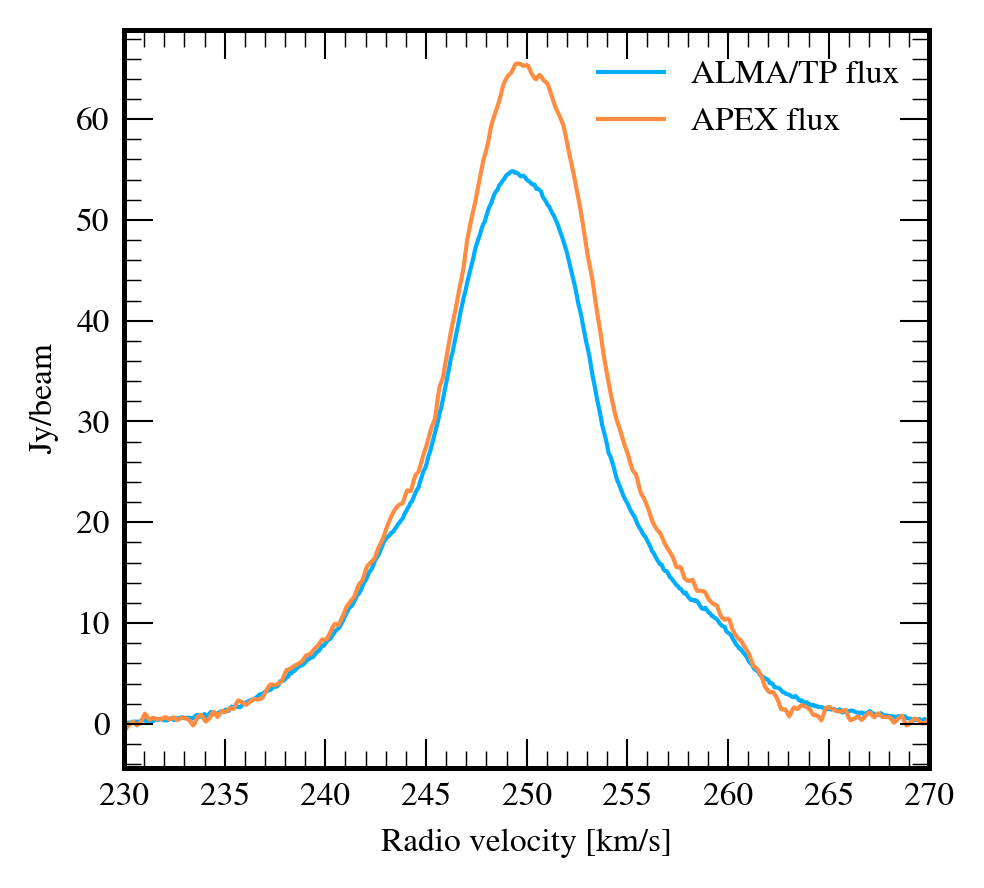

In [118]:
def APEX_TP_spec():
    #plt.figure(figsize=(4,3.3))
    vel, APEX_flux = np.loadtxt('/home/luuk/Documents/APEX.txt', unpack=True)
    vel, TP_flux = np.loadtxt('/home/luuk/Documents/TP_APEX_spec.txt', unpack=True)
    plt.plot(vel,TP_flux, label='ALMA/TP flux',lw=1)
    plt.plot(vel,APEX_flux,label='APEX flux', lw=1)
    plt.xlim(230,270)
    plt.xlabel('Radio velocity [km/s]')
    plt.ylabel('Jy/beam')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ALMA_TP_spec.pdf')
APEX_TP_spec()

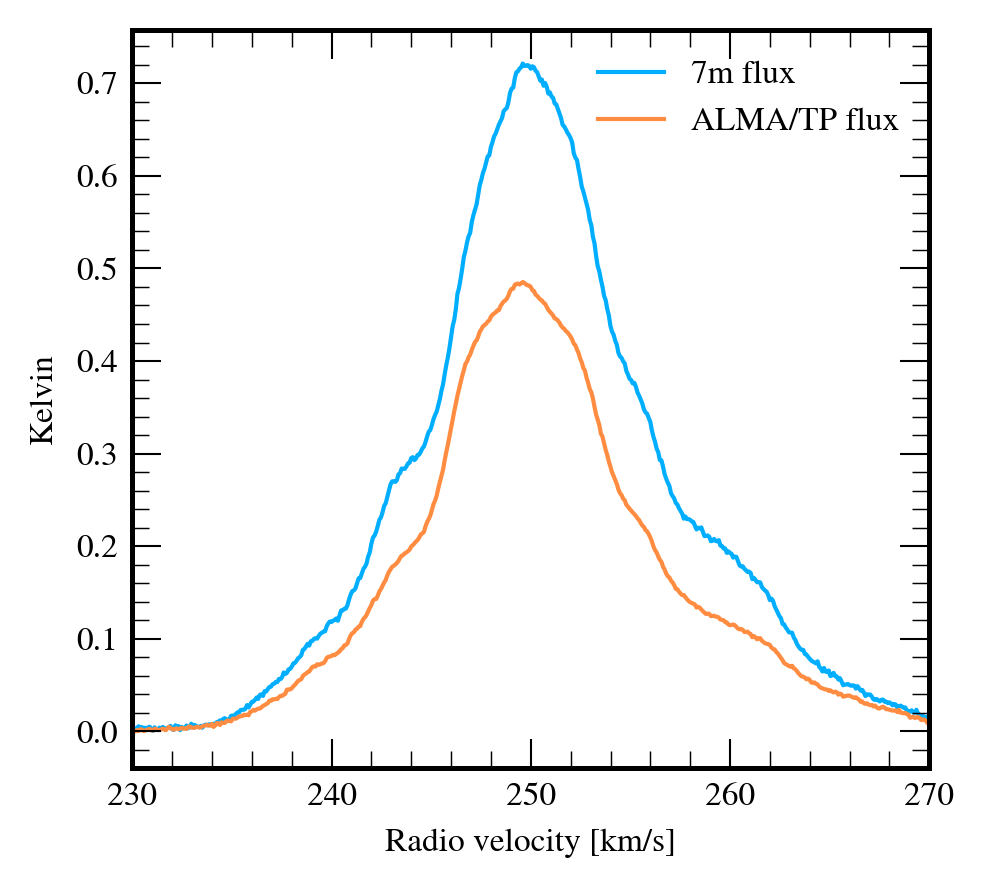

In [122]:
def _7m_TP_spec():
    #plt.figure(figsize=(4,3.3))
    vel, _7m_flux = np.loadtxt('/home/luuk/Documents/7m_mosaic_CO_spectra.txt', unpack=True)
    vel, TP_flux = np.loadtxt('/home/luuk/Documents/TP_spectrum_for7mregion.txt', unpack=True)
    
    plt.plot(vel,_7m_flux,label='7m flux', lw=1)
    plt.plot(vel,TP_flux, label='ALMA/TP flux',lw=1)
    plt.xlim(230,270)
    plt.xlabel('Radio velocity [km/s]')
    plt.ylabel('Kelvin')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ALMA_TP_7m_spec.pdf')
_7m_TP_spec()